In [1]:
import healpy as hp
import numpy as np
import math
import pandas as pd
import seaborn as sns
from tqdm import tqdm, tqdm_notebook
from scipy.special import erf

import copy
import sys
from my_units import * 

from angular_fn import *
from template_fn import *
from cov_matrix_fn import *

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable


'''plt.rcdefaults()
from matplotlib import font_manager
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import colors

rcParams['mathtext.rm'] = 'Computer Modern'
rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'
'''

HomeDir = './'
#DataDir = HomeDir #+ 'code/'
DataDir = '/Users/crimondino/Dropbox (PI)/LensVelocity2/data/pairs_ruwe_dist/'#HomeDir #+ 'code/'

### Set this to the directory where you store your data files (see below how to download them)
ListDir = HomeDir+'lists/hist_stats/'
FigDir = HomeDir+'figures/'

# Read in Files

In [2]:
df_back = pd.read_csv(DataDir+'bg_subtracted.csv') 
print('Backgrounds read in.')

df_fore = pd.read_csv(DataDir+'fg_subtracted.csv')
print('Foregrounds read in.')
len(df_back)

Backgrounds read in.
Foregrounds read in.


7339097

In [739]:
### Select only the closest foreground stars
#df_back = df_back.iloc[df_fore['dist_50'].to_numpy()<500]
#df_fore = df_fore.iloc[df_fore['dist_50'].to_numpy()<500]
len(df_fore)

In [786]:
len(df_back[df_fore['dist_50'].to_numpy()<100])

35502

## old code

In [2]:
df_back = pd.read_csv(DataDir+'pairs_background_ruwe_w_st.csv', usecols = ['ra', 'dec', 'pmra', 'pmdec','pmra_error', 'pmdec_error', 'pmra_pmdec_corr', 'pmra_eff_error', 'pmdec_eff_error', 'pmra_pmdec_eff_corr', 'parallax', 'parallax_error', 'parallax_eff_error', 'pmra_sub', 'pmdec_sub', 'ecl_lon', 'ecl_lat', 'l', 'b', 'ruwe'])
print('Backgrounds read in.')

df_fore = pd.read_csv(DataDir+'pairs_foreground_ruwe_w_st.csv', usecols = ['ra', 'dec', 'pmra', 'pmdec','pmra_error', 'pmdec_error', 'parallax', 'parallax_error', 'phot_g_mean_mag', 'ecl_lon', 'ecl_lat', 'l', 'b', 'ruwe'])
print('Foregrounds read in.')

back_dist = pd.read_csv('bg_dist.csv', header=None)
fore_dist = pd.read_csv('fg_dist.csv', header=None)

Backgrounds read in.
Foregrounds read in.


In [3]:
### load in indices of stars that "survived" the subtraction process (ruwe < 1.4, not outlier) 

bg_sub_ind = np.load('tmu_ind.npy')

df_back = df_back.loc[bg_sub_ind]
df_fore = df_fore.loc[bg_sub_ind]
back_dist = back_dist.loc[bg_sub_ind]
fore_dist = fore_dist.loc[bg_sub_ind]

df_back.shape

(8763142, 20)

In [4]:
df_back = df_back.reset_index()
df_fore = df_fore.reset_index()
back_dist = back_dist.reset_index()
fore_dist = fore_dist.reset_index()

In [5]:
### load in new subtractions
new_sub = pd.read_csv('new_sub.csv', usecols=['pmra_sub_new', 'pmdec_sub_new', 'pmra_eff_error_new',
       'pmdec_eff_error_new', 'pmra_pmdec_eff_corr_new'])

In [6]:
new_sub

,pmra_sub_new,pmdec_sub_new,pmra_eff_error_new,pmdec_eff_error_new,pmra_pmdec_eff_corr_new
0,-0.265639,-1.433541,1.048995,1.464768,-0.037695
1,0.639632,-0.388836,1.048995,1.464768,-0.074210
2,0.342923,-3.928524,1.048995,1.464768,-0.053853
3,0.125175,0.612223,1.048995,1.464768,-0.039847
4,-1.488503,-1.430796,1.048995,1.464768,-0.055005
...,...,...,...,...,...
8763137,0.267562,3.744027,3.028023,2.787486,0.148879
8763138,5.876851,-1.506965,3.055063,2.788147,0.136006
8763139,4.819424,1.742081,3.430736,3.214288,-0.006314
8763140,-2.938167,-1.353771,3.118294,3.411297,0.304556


In [7]:
df_back = df_back.join(new_sub)
df_back['dist'] = back_dist[1]
df_fore['dist'] = fore_dist[1]

# Template functions

In [4]:
## redefine cov matrix
def fn_cov_pm_eff(df):
    """
    Given a panda data frame df, returns the effective covariance matrix for (pmra, pmdec).
    """
    return np.array([[df['pmra_eff_error_new']**2, df['pmra_pmdec_eff_corr_new']*df['pmra_eff_error_new']*df['pmdec_eff_error_new']], 
                     [df['pmra_pmdec_eff_corr_new']*df['pmra_eff_error_new']*df['pmdec_eff_error_new'], df['pmdec_eff_error_new']**2]]).T
    #return np.array([[df['pmra_eff_error_new']**2, np.zeros(len(df))], 
    #                 [np.zeros(len(df)), df['pmdec_eff_error_new']**2]]).T

In [5]:
### Functions for the lens-induced proper motion, parallax and acceleration.

### !!!!! NOTICE that the functions below take into account the finite distance of the background source as well (in the magnitude of the lensing and in the relative velocity between the source and the lens). 
### For background stars that have a negative parallax measurement and or compatible with zero at 2-3*sigma, the coefficient (1-bg_parallax/fg_parallax) should probably be discrded.

def fn_lensing_pm(fg_ra, fg_dec, fg_pmra, fg_pmdec, fg_dist, bg_ra, bg_dec, bg_pmra, bg_pmdec, bg_dist, tau_obs, matched_filter=fn_dipole_mf):
    """
    Computes the lens-induced proper motion on background stars due to the foreground stars. In the template regime, the impact parameter must be larger than the distance travelled by the lens during the observation time tau_obs.    
    Output: list of 2d proper motion vectors (in mas/y) and indices of pairs with impact parameter in the template regime (the other pairs should be discarded).
    """
    l_bilvec = fn_angular_sep(fg_ra*degree, fg_dec*degree, bg_ra*degree, bg_dec*degree)
    l_bilnormsq = l_bilvec[:, 0]**2 + l_bilvec[:, 1]**2
    l_bilhat = np.array([l_bilvec[:, 0]/np.sqrt(l_bilnormsq), l_bilvec[:, 1]/np.sqrt(l_bilnormsq)]).T 
    l_muvec = np.array([fg_pmra - bg_pmra, fg_pmdec - bg_pmdec]).T*mas/Year
    #l_muvec = np.array([fg_pmra, fg_pmdec]).T*mas/Year
    l_munorm = np.sqrt(l_muvec[:, 0]**2 + l_muvec[:, 1]**2)
    l_muhat = np.array([l_muvec[:, 0]/l_munorm, l_muvec[:, 1]/l_munorm]).T 
    l_Dl = fg_dist * pc
    ### Evaluating the matched filter
    l_dipole_vec = matched_filter(l_muhat, l_bilhat)
    
    '''pm_list = np.array([-4*GN*MSolar*l_munorm/l_Dl/l_bilnormsq*l_dipole_vec[:, 0], 
                        -4*GN*MSolar*l_munorm/l_Dl/l_bilnormsq*l_dipole_vec[:, 1]]).T'''
    
    pm_list = np.array([-(1-fg_dist / bg_dist)*4*GN*MSolar*l_munorm/l_Dl/l_bilnormsq*l_dipole_vec[:, 0], 
                        -(1-fg_dist / bg_dist)*4*GN*MSolar*l_munorm/l_Dl/l_bilnormsq*l_dipole_vec[:, 1]]).T
    #pm_list = np.array([-4*GN*MSolar*l_munorm/l_Dl*l_dipole_vec[:, 0]/l_bilnormsq, 
    #                    -4*GN*MSolar*l_munorm/l_Dl*l_dipole_vec[:, 1]/l_bilnormsq]).T
    
    return pm_list[l_bilnormsq > (l_munorm*tau_obs)**2]/(mas/Year), np.arange(len(fg_ra))[l_bilnormsq > (l_munorm*tau_obs)**2]

In [6]:
def fn_tau_mu(df_fore, df_back, weights, tau_obs, tau_max=False, matched_filter=fn_dipole_mf, rot_angle=False, quiet=True):
    """
    For a given data frame of foreground and background stars, return the proper motion tau test statistic and its normalization.
    Weights must be an array of 2x2 matrices of the same lenght of df_fore and df_back, e.g. the pm inverse covariance matrix for each background star.
    If tau_max!=False, only the values of tau < tau_max are kept in the sum over all pairs. 
    """
    
    if not quiet: print('Computing the expected velocity.'); sys.stdout.flush()
    lensing_pm, good_bil_ind = fn_lensing_pm(df_fore['ra'].to_numpy(), df_fore['dec'].to_numpy(),
                                             df_fore['pmra'].to_numpy(),  df_fore['pmdec'].to_numpy(), df_fore['dist_50'].to_numpy(),
                                             df_back['ra'].to_numpy(), df_back['dec'].to_numpy(),
                                             df_back['pmra'].to_numpy(), df_back['pmdec'].to_numpy(), df_back['dist_50'].to_numpy(), tau_obs, matched_filter)

    if(len(lensing_pm) < len(df_back)):
        if not quiet: print((len(df_back)-len(lensing_pm)), 'star pairs have too small impact parameter. Selecting only the good pairs.'); sys.stdout.flush()
        df_back = df_back.iloc[good_bil_ind]; weights = weights[good_bil_ind]
    
    if rot_angle:
        if not quiet: print('Rotating the dipole profile by', rot_angle/degree, 'deg'); sys.stdout.flush()
        costh, sinth = np.cos(rot_angle), np.sin(rot_angle)
        lensing_pm = np.array([lensing_pm[:,0]*costh-lensing_pm[:,1]*sinth, lensing_pm[:,1]*costh+lensing_pm[:,0]*sinth]).T


    if not quiet: print('Computing the tau lists.'); sys.stdout.flush()
    ### Observed background stars' proper motion (after subtraction)
    observed_pm = np.array([df_back['pmra_sub_new'].to_numpy(), df_back['pmdec_sub_new'].to_numpy()]).T
    #tau_norm_sq = weights[:, 0, 0]*lensing_pm[:, 0]**2 + weights[:, 1, 1]*lensing_pm[:, 1]**2 + 2*weights[:, 0, 1]*lensing_pm[:, 0]*lensing_pm[:, 1]
    tau_norm_sq = (lensing_pm[:, 0]**2 + lensing_pm[:, 1]**2)/(1/weights[:, 0, 0] + 1/weights[:, 1, 1]) 
    tau_mu = (weights[:, 0, 0]*lensing_pm[:, 0]*observed_pm[:, 0] + weights[:, 1, 1]*lensing_pm[:, 1]*observed_pm[:, 1] + 
              weights[:, 0, 1]*(lensing_pm[:, 0]*observed_pm[:, 1] + lensing_pm[:, 1]*observed_pm[:, 0]))

    if not quiet: print('Computing the sum.'); sys.stdout.flush()
    if tau_max!=0:
        small_tau_mu = tau_mu[np.abs(tau_mu) < tau_max]
        if not quiet: print(str((1-len(small_tau_mu)/len(tau_mu))*100)+'% of taus removed')
        return sum(small_tau_mu), np.sqrt(sum(tau_norm_sq[np.abs(tau_mu) < tau_max]))
    else:
        return tau_mu, tau_norm_sq, good_bil_ind # sum(tau_mu), np.sqrt(sum(tau_norm_sq))    

# Evaluation

In [7]:
tau_obs = 2.833*Year

In [8]:
inv_cov_pm = np.linalg.inv(fn_cov_pm_eff(df_back))

In [9]:
tau_mu_list, tau_norm_sq_list, good_bil_ind = fn_tau_mu(df_fore, df_back, inv_cov_pm, tau_obs, tau_max=False, matched_filter=fn_dipole_mf, rot_angle=False, quiet=False)
tau_mu, tau_norm = sum(tau_mu_list), np.sqrt(sum(tau_norm_sq_list))  

Computing the expected velocity.
13 star pairs have too small impact parameter. Selecting only the good pairs.
Computing the tau lists.
Computing the sum.


In [10]:
tau_mu_list_90deg, tau_norm_sq_list_90deg, good_bil_ind = fn_tau_mu(df_fore, df_back, inv_cov_pm, tau_obs, tau_max=False, matched_filter=fn_dipole_mf, rot_angle=np.pi/4, quiet=True)
tau_mu_90deg, tau_norm_90deg = sum(tau_mu_list_90deg), np.sqrt(sum(tau_norm_sq_list_90deg))  

In [11]:
tau_mu_list_mon, tau_norm_sq_list_mon, good_bil_ind = fn_tau_mu(df_fore, df_back, inv_cov_pm, tau_obs, tau_max=False, matched_filter=fn_monopole_mf, rot_angle=np.pi/4, quiet=True)
tau_mu_mon, tau_norm_mon = sum(tau_mu_list_mon), np.sqrt(sum(tau_norm_sq_list_mon))  

In [12]:
print('T   : ' + str(tau_mu))
print('N   : ' + str(tau_norm))
print('T/N : ' + str(tau_mu/tau_norm))

T   : 0.5712459604237192
N   : 0.20165475814568037
T/N : 2.832791874967994


In [13]:
print('Dipole rotated by 90 degrees')
print('T   : ' + str(tau_mu_90deg))
print('N   : ' + str(tau_norm_90deg))
print('T/N : ' + str(tau_mu_90deg/tau_norm_90deg))

Dipole rotated by 90 degrees
T   : 0.7250174384019812
N   : 0.20165475814568037
T/N : 3.5953401004215864


In [14]:
print('Monopole')
print('T   : ' + str(tau_mu_mon))
print('N   : ' + str(tau_norm_mon))
print('T/N : ' + str(tau_mu_mon/tau_norm_mon))

Monopole
T   : 0.868060616239794
N   : 0.2016547581456804
T/N : 4.304687001794847


In [17]:
from scipy.stats import norm
  
# Fit a normal distribution to the distribution of T/N
mu, std = norm.fit(tau_mu_list/np.sqrt(tau_norm_sq_list)) 

In [25]:
max(h[0])

0.31080634043956806

In [33]:
max(norm.pdf(np.linspace(-3.1, 3.1, 70), mu, std)), max(h[0])

(0.27725404284304866, 0.31080634043956806)

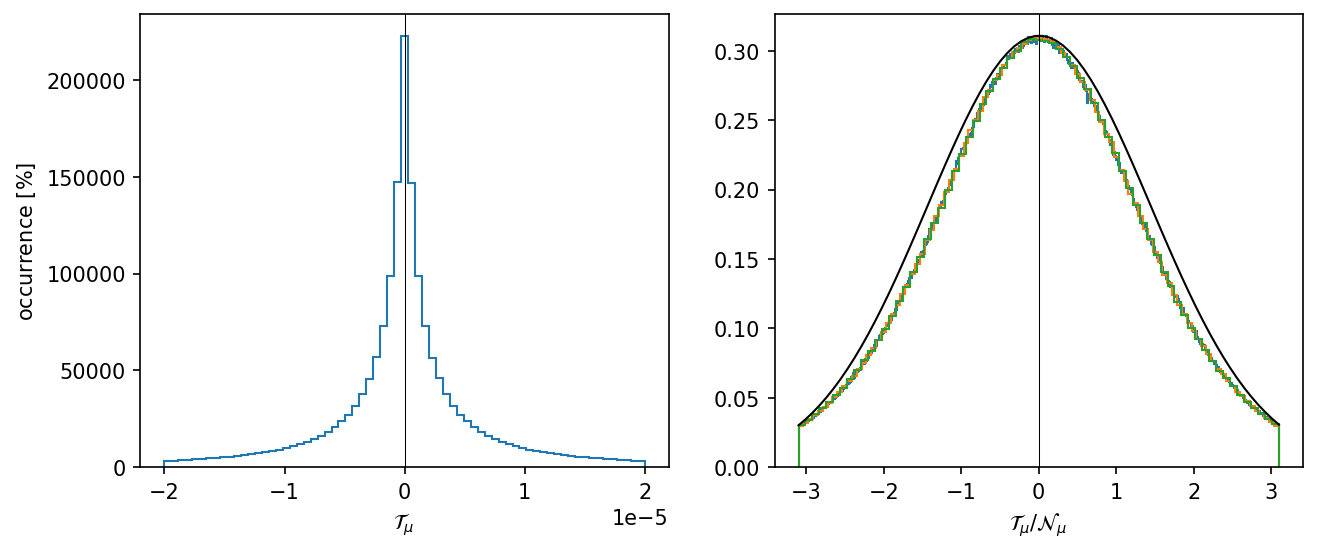

In [34]:
fig,ax = plt.subplots(1,2,figsize=(10,4), dpi = 150)

ax[0].hist(tau_mu_list, bins=np.linspace(-0.00002, 0.00002, 70), log=False, density=True, histtype='step');
ax[0].set_xlabel(r'$\mathcal{T}_{\mu}$ '); ax[0].set_ylabel(r'occurrence [$\%$]');
ax[0].axvline(0, color='k', linewidth=0.5)

h = ax[1].hist(tau_mu_list/np.sqrt(tau_norm_sq_list), bins=np.linspace(-3.1, 3.1, 500), log=False, density=True, histtype='step');
ax[1].hist(tau_mu_list_90deg/np.sqrt(tau_norm_sq_list_90deg), bins=np.linspace(-3.1, 3.1, 100), log=False, density=True, histtype='step');
ax[1].hist(tau_mu_list_mon/np.sqrt(tau_norm_sq_list_mon), bins=np.linspace(-3.1, 3.1, 70), log=False, density=True, histtype='step');
ax[1].set_xlabel(r'$\mathcal{T}_{\mu}/\mathcal{N}_{\mu}$ ');
ax[1].axvline(0, color='k', linewidth=0.5)
ax[1].plot(np.linspace(-3.1, 3.1, 70),  max(h[0])*norm.pdf(np.linspace(-3.1, 3.1, 70), mu, std)/max(norm.pdf(np.linspace(-3.1, 3.1, 70), mu, std)), 'k', linewidth=1)
#ax[1].set_yscale('log')  

# Dependence on foreground distance

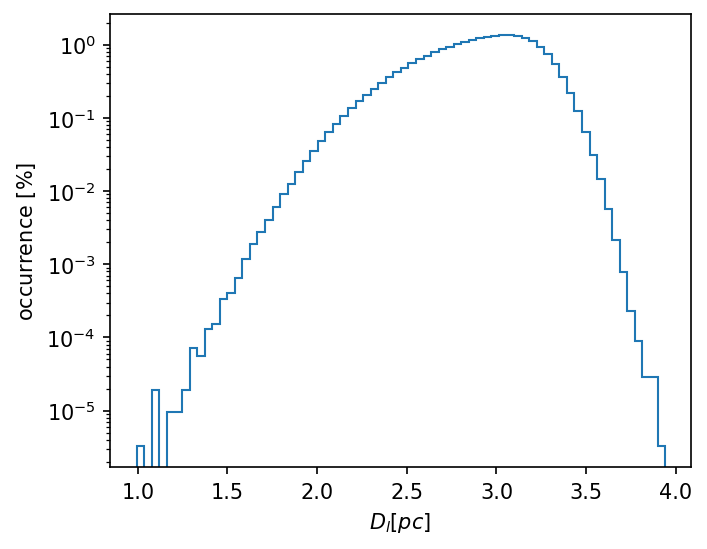

In [19]:
fig,ax = plt.subplots(1,1,figsize=(5,4), dpi = 150)

ax.hist(np.log10(df_fore['dist_50'].to_numpy()), bins=70, log=True, density=True, histtype='step');
ax.set_xlabel(r'$D_l [pc]$ '); ax.set_ylabel(r'occurrence [$\%$]');

In [62]:
dist_bins = np.logspace(1, 4, num=30)
dist_bins

array([   10.        ,    12.68961003,    16.10262028,    20.43359718,
          25.92943797,    32.90344562,    41.75318937,    52.98316906,
          67.23357536,    85.31678524,   108.26367339,   137.38237959,
         174.33288222,   221.22162911,   280.72162039,   356.22478903,
         452.03536564,   573.61525104,   727.8953844 ,   923.67085719,
        1172.10229753,  1487.35210729,  1887.39182214,  2395.02661999,
        3039.19538231,  3856.62042116,  4893.90091848,  6210.16941892,
        7880.46281567, 10000.        ])

In [69]:
tau_d = np.zeros(len(dist_bins)-1)
n_d = np.zeros(len(dist_bins)-1)
n_pairs = np.zeros(len(dist_bins)-1)
d_avg = np.zeros(len(dist_bins)-1)

for i_d in range(len(dist_bins)-1):
    pairs_d = ((df_fore['dist_50'].to_numpy() > dist_bins[i_d]) & (df_fore['dist_50'].to_numpy() < dist_bins[i_d+1]))
    n_pairs[i_d] = len(df_fore[pairs_d])
    tau_d[i_d] = np.sum(tau_mu_list[pairs_d])
    n_d[i_d] = np.sqrt(np.sum(tau_norm_sq_list[pairs_d]))
    d_avg[i_d] = np.mean((df_fore['dist_50'].to_numpy())[pairs_d])

In [52]:
np.sum(n_pairs), len(df_fore)

(7339083.0, 7339084)

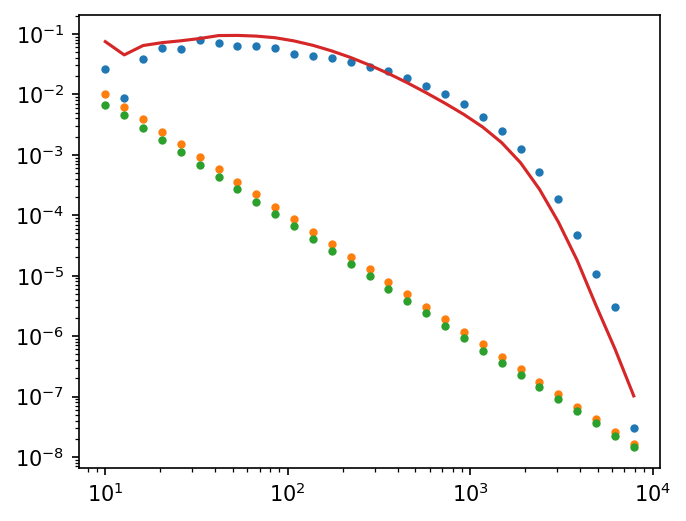

In [77]:
fig,ax = plt.subplots(1,1,figsize=(5,4), dpi = 150)

ax.plot(dist_bins[:-1], n_d, '.');
ax.plot(dist_bins[:-1], 1/dist_bins[:-1]**2, '.');
ax.plot(dist_bins[:-1], 1/d_avg**2, '.');
#ax.plot(dist_bins[:-1], tau_d/n_d, '-');
ax.plot(dist_bins[:-1], 5*np.sqrt(n_pairs)/d_avg**2, '-');

ax.set_yscale('log')
ax.set_xscale('log')


In [122]:
bins_bil = np.arange(0.6, 3.2, 0.2)

In [128]:
tau_b = np.zeros(len(bins_bil)-1)
n_b = np.zeros(len(bins_bil)-1)
n_pairs_b = np.zeros(len(bins_bil)-1)
bil_avg = np.zeros(len(bins_bil)-1)

for i_b in range(len(bins_bil)-1):
    pairs_b = ((np.sqrt(l_bilnormsq)/arcsec > bins_bil[i_b]) & (np.sqrt(l_bilnormsq)/arcsec < bins_bil[i_b+1]))
    n_pairs_b[i_b] = len(df_fore[pairs_b])
    tau_b[i_b] = np.sum(tau_mu_list[pairs_b])
    n_b[i_b] = np.sqrt(np.sum(tau_norm_sq_list[pairs_b]))
    bil_avg[i_b] = np.mean(np.sqrt(l_bilnormsq)[pairs_d])/arcsec

In [131]:
len(tau_b), len(bins_bil)

(12, 13)

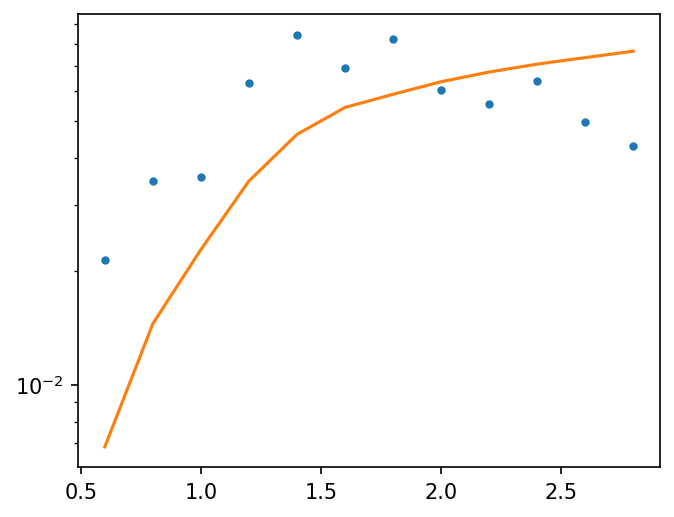

In [135]:
fig,ax = plt.subplots(1,1,figsize=(5,4), dpi = 150)

ax.plot(bins_bil[:-1], n_b, '.');
#ax.plot(bins_bil[:-1], 1/dist_bins[:-1]**2, '.');
#ax.plot(bins_bil[:-1], 1/d_avg**2, '.');
#ax.plot(bins_bil[:-1], tau_b/n_b, '-');
ax.plot(bins_bil[:-1], 0.0005*np.sqrt(n_pairs_b)/bil_avg**2, '-');
#ax.plot(bins_bil[:-1], n_pairs_b, '-');

ax.set_yscale('log')
#ax.set_xscale('log')


# Astrophysical parameters

In [3]:
df_fore_params = pd.read_csv(DataDir+'fg_params.csv') 
df_fore_params

,Unnamed: 0,source_id,mass,mass_lower,mass_upper,lum,lum_lower,lum_upper,teff,teff_lower,teff_upper,mg,mg_lower,mg_upper
0,0,8250632981888,NaN,NaN,NaN,NaN,NaN,NaN,5562.0205,5548.3700,5584.4165,6.0129,5.8658,6.0980
1,1,17390323414528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,44362718023680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,116479515230592,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,250658586976512,NaN,NaN,NaN,1.039218,0.999042,1.080230,5161.6987,5141.6187,5196.9756,4.8155,4.7505,4.8430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8117464,8117464,6917468043401298944,1.490971,1.447693,1.535409,7.296951,6.766074,7.726905,5176.8555,5162.7075,5191.8600,2.6001,2.5298,2.6619
8117465,8117465,6917478145164462592,NaN,NaN,NaN,0.026552,0.021525,0.031566,3481.4102,3471.9243,3491.8958,9.3582,9.3366,9.3774
8117466,8117466,6917488998547840384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8117467,8117467,6917516250114305920,NaN,NaN,NaN,0.046483,0.040498,0.052167,3636.0720,3617.5810,3654.6210,8.1707,7.8149,8.6353


In [4]:
### Check how many stars have a measurement
len(df_fore_params[~np.isnan(df_fore_params['teff'])]), len(df_fore_params[~np.isnan(df_fore_params['lum'])]), len(df_fore_params[~np.isnan(df_fore_params['mass'])])

(4354156, 3831306, 2705730)

In [6]:
### Take only the stars that have a measurement and remove repeated entries
df_fore_params = df_fore_params[~np.isnan(df_fore_params['teff'])]

### Remove duplicates
aa, params_unique = np.unique(df_fore_params['source_id'].to_numpy(), return_index=True)
df_fore_params = df_fore_params.iloc[params_unique]
print(len(df_fore_params))
id_params = df_fore_params['source_id'].to_numpy()

4078217


In [7]:
### Take source id of our sample and remove repeated entries
id_sub = df_fore['source_id'].to_numpy()
id_sub_unique, index_unique, inverse, count = np.unique(id_sub, return_index=True, return_inverse=True, return_counts=True)

In [8]:
### Data frame with the unique entries
df_fore_unique = pd.DataFrame(data={'source_id': id_sub_unique})

In [9]:
### Find intersection between the two lists
id_inter, index_sub, index_params = np.intersect1d(id_sub_unique, id_params, assume_unique=True, return_indices=True)
len(id_inter)

2739318

In [21]:
temp_param_list = np.zeros((len(id_sub_unique), 13))*np.nan
temp_param_list[index_sub] = df_fore_params.iloc[index_params][['source_id', 'mass', 'mass_lower', 'mass_upper', 'lum', 'lum_lower', 'lum_upper', 'teff', 'teff_lower', 'teff_upper', 'mg', 'mg_lower', 'mg_upper']]
len(temp_param_list[:, 0][~np.isnan(temp_param_list[:, 0])])

2739318

In [22]:
df_fore_unique[['source_id', 'mass', 'mass_lower', 'mass_upper', 'lum', 'lum_lower', 'lum_upper', 'teff', 'teff_lower', 'teff_upper', 'mg', 'mg_lower', 'mg_upper']] = temp_param_list
df_fore_unique

,source_id,mass,mass_lower,mass_upper,lum,lum_lower,lum_upper,teff,teff_lower,teff_upper,mg,mg_lower,mg_upper
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.076701e+17,1.214308,1.173185,1.255680,2.367251,2.188008,2.549838,6341.7954,6317.4650,6363.9277,3.8344,3.7630,3.9016
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6447370,6.764393e+18,1.750565,1.710562,1.790567,13.602947,12.544752,14.872297,5955.6520,5947.8980,5963.9850,0.7768,0.7556,0.7808
6447371,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6447372,6.764400e+18,0.704072,0.662413,0.744423,0.153578,0.136606,0.168160,4406.1030,4397.0923,4418.5996,7.0442,7.0171,7.0707
6447373,6.764404e+18,0.709516,0.668283,0.753332,0.199445,0.171439,0.229172,4447.7800,4412.6753,4477.3447,7.1533,7.0829,7.2348


In [23]:
len(df_fore_unique[~np.isnan(df_fore_unique['mass'])])

1742211

In [25]:
columns_to_add = ['mass', 'mass_lower', 'mass_upper', 'lum', 'lum_lower', 'lum_upper', 'teff', 'teff_lower', 'teff_upper', 'mg', 'mg_lower', 'mg_upper']

for col in columns_to_add:
    df_fore[col] = df_fore_unique.iloc[inverse][col].to_numpy()

In [195]:
#df_fore['mass'] = df_fore_unique.iloc[inverse]['mass'].to_numpy()

In [200]:
#df_fore['source_id_2'] = df_fore_unique.iloc[inverse]['source_id'].to_numpy()
#aa = df_fore['source_id_2']/df_fore['source_id']
#aa[np.abs(aa-1)>0.0001]

In [27]:
len(df_fore[~np.isnan(df_fore['mass'])])/len(df_fore)

0.25395344958650906

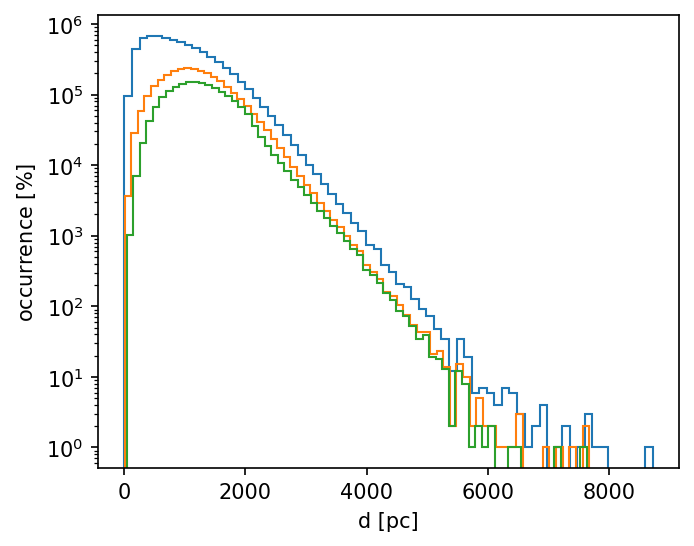

In [29]:
fig,ax = plt.subplots(1,1,figsize=(5,4), dpi = 150)

ax.hist(df_fore['dist_50'].to_numpy(), bins=70, log=True, density=False, histtype='step');
ax.hist(df_fore[~np.isnan(df_fore['teff'])]['dist_50'].to_numpy(), bins=70, log=True, density=False, histtype='step');
ax.hist(df_fore[~np.isnan(df_fore['mass'])]['dist_50'].to_numpy(), bins=70, log=True, density=False, histtype='step');
ax.set_xlabel(r'd [pc]'); ax.set_ylabel(r'occurrence [$\%$]');

In [ ]:
df_back.to_csv(DataDir+'bg_subtracted.csv', index=False, chunksize=100000)

# Plots

In [26]:
df_back = df_back.iloc[good_bil_ind]
df_fore = df_fore.iloc[good_bil_ind]

In [81]:
fg_ra = df_fore['ra'] 
fg_dec = df_fore['dec']
fg_pmra= df_fore['pmra'] 
fg_pmdec= df_fore['pmdec']

bg_ra = df_back['ra']
bg_dec = df_back['dec'] 
bg_pmra= df_back['pmra_sub_new'] 
bg_pmdec= df_back['pmdec_sub_new'] 

#bil separation vectors
l_bilvec = fn_angular_sep(fg_ra*degree, fg_dec*degree, bg_ra*degree, bg_dec*degree)
l_bilnormsq = l_bilvec[:, 0]**2 + l_bilvec[:, 1]**2

l_bilhat = np.array([l_bilvec[:, 0]/np.sqrt(l_bilnormsq), l_bilvec[:, 1]/np.sqrt(l_bilnormsq)]).T 
l_bilhatperp = np.array([-l_bilhat[:, 1], l_bilhat[:, 0]]).T

#foreground mu vectors
l_muvec = np.array([fg_pmra, fg_pmdec]).T*mas/Year
#l_muvec = np.array([fg_pmra - bg_pmra, fg_pmdec - bg_pmdec]).T*mas/Year

l_munormsq = l_muvec[:, 0]**2 + l_muvec[:, 1]**2
l_muhat = np.array([l_muvec[:, 0]/np.sqrt(l_munormsq), l_muvec[:, 1]/np.sqrt(l_munormsq)]).T 
l_muhatperp = np.array([-l_muhat[:, 1], l_muhat[:, 0]]).T

# project bil onto fg mu
df_back['dotprod_bil'] = (l_bilvec[:,0]*l_muhat[:,0] + l_bilvec[:,1]*l_muhat[:,1])/arcsec
df_back['dotperp_bil'] = (l_bilvec[:,0]*l_muhatperp[:,0] + l_bilvec[:,1]*l_muhatperp[:,1])/arcsec

# bg's motion parallel to and perpendicular to fg's motion
df_back['mu_par'] = (bg_pmra*l_muhat[:,0] + bg_pmdec*l_muhat[:,1])
df_back['mu_perp'] = (bg_pmra*l_muhatperp[:,0] + bg_pmdec*l_muhatperp[:,1])

In [817]:
### Histogram for the figure of merit sqrt(N)/(beta*sigma_mu)
n_bins = 100

hist_count, bin_x, bin_y = np.histogram2d(df_back['dotprod_bil'], df_back['dotperp_bil'], bins=n_bins)
hist_sigmamusq_inv = np.histogram2d(df_back['dotprod_bil'], df_back['dotperp_bil'], bins=n_bins, weights=1/(df_back['pmra_eff_error_new'].to_numpy()**2+df_back['pmdec_eff_error_new'].to_numpy()**2))[0]
hist_sigmamusq_inv = hist_sigmamusq_inv/hist_count
hist_beta = np.histogram2d(df_back['dotprod_bil'], df_back['dotperp_bil'], bins=n_bins, weights=np.sqrt(l_bilnormsq)/arcsec)[0]
hist_beta = hist_beta/hist_count

<ipython-input-817-d2fd1ffc9e22>:6: RuntimeWarning: invalid value encountered in true_divide
  hist_sigmamusq_inv = hist_sigmamusq_inv/hist_count
<ipython-input-817-d2fd1ffc9e22>:8: RuntimeWarning: invalid value encountered in true_divide
  hist_beta = hist_beta/hist_count


In [818]:
hist_Dl = np.histogram2d(df_back['dotprod_bil'], df_back['dotperp_bil'], bins=n_bins, weights=df_fore['dist_50'])[0]
hist_Dl = hist_Dl/hist_count

<ipython-input-818-a5fb80f374e5>:2: RuntimeWarning: invalid value encountered in true_divide
  hist_Dl = hist_Dl/hist_count


In [819]:
#l_muvec_1 = np.array([df_fore['pmra'].to_numpy()-df_back['pmra'].to_numpy(), df_fore['pmdec'].to_numpy()-df_back['pmdec'].to_numpy()]).T*mas/Year
l_muvec_1 = np.array([df_fore['pmra'].to_numpy(), df_fore['pmdec'].to_numpy()]).T
l_munorm_1 = np.sqrt(l_muvec_1[:, 0]**2 + l_muvec_1[:, 1]**2)
(l_munorm_1**2).shape

(1809437,)

In [763]:
np.min(tau_norm_sq_list), np.max(tau_norm_sq_list)

(3.750969117938685e-17, 0.002361946711998665)

In [872]:
len(tau_norm_sq_list[:36000*50])/36000

50.0

In [890]:
tau_norm_sq_sub =  np.array(np.split(tau_norm_sq_list[:36000*50], 50))

np.sum(tau_norm_sq_sub.T, axis=1)

array([7.24773662e-08, 6.81961941e-08, 7.53041668e-08, ...,
       8.28526921e-08, 1.45241113e-07, 2.09667869e-07])

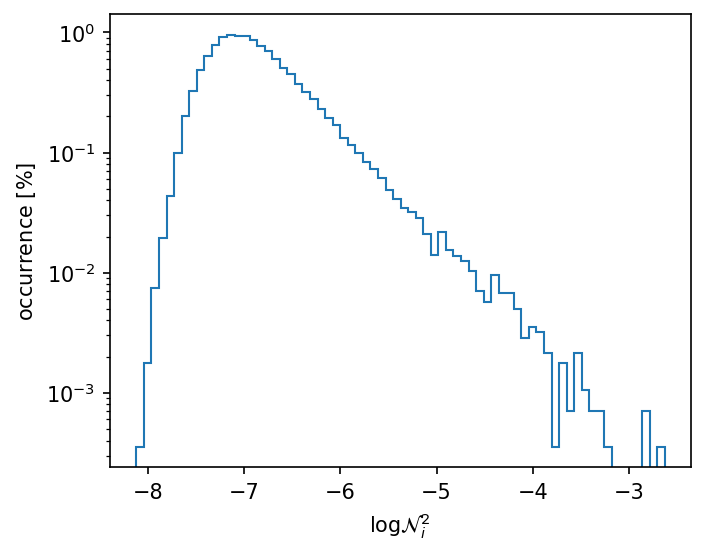

In [891]:
fig,ax = plt.subplots(1,1,figsize=(5,4), dpi = 150)

ax.hist(np.log10(np.sum(tau_norm_sq_sub.T, axis=1)), bins=70, log=True, density=True, histtype='step');
ax.set_xlabel(r'$\log \mathcal{N}_i^2$ '); ax.set_ylabel(r'occurrence [$\%$]');

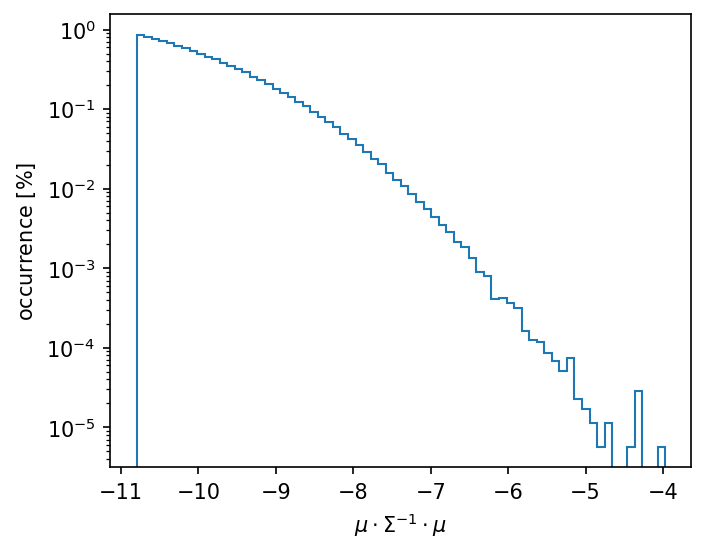

In [785]:
fig,ax = plt.subplots(1,1,figsize=(5,4), dpi = 150)

ax.hist(np.log10(1/df_fore['dist_50'].to_numpy()**4), bins=70, log=True, density=True, histtype='step');
ax.set_xlabel(r'$\mu \cdot \Sigma^{-1} \cdot \mu$ '); ax.set_ylabel(r'occurrence [$\%$]');

In [840]:
#hist_mufg = np.histogram2d(df_back['dotprod_bil'], df_back['dotperp_bil'], bins=n_bins, weights=np.sqrt( ( (df_fore['pmra'].to_numpy()-df_back['pmra'].to_numpy())**2/df_back['pmra_eff_error_new'].to_numpy()**2 + 
#                                                                                                           (df_fore['pmdec'].to_numpy()-df_back['pmdec'].to_numpy())**2/df_back['pmdec_eff_error_new'].to_numpy()**2) ))[0]
#hist_mufg = np.histogram2d(df_back['dotprod_bil'], df_back['dotperp_bil'], bins=n_bins, weights=1/(df_back['pmra_eff_error_new'].to_numpy()**2 + df_back['pmdec_eff_error_new'].to_numpy()**2)/df_fore['dist_50'].to_numpy()**2/l_bilnormsq**2  )[0]
hist_mufg = np.histogram2d(df_back['dotprod_bil'], df_back['dotperp_bil'], bins=n_bins, weights=1/l_bilnormsq**2  )[0]
#hist_mufg = np.histogram2d(df_back['dotprod_bil'], df_back['dotperp_bil'], bins=n_bins, weights=l_munorm_1**2/df_fore['dist_50'].to_numpy()**2  )[0]
hist_mufg = hist_mufg

In [821]:
hist_mufg.flatten()/np.max(hist_mufg[~np.isnan(hist_mufg)])/(hist_nsq.flatten()/np.max(hist_nsq[~np.isnan(hist_nsq)]))

ValueError: operands could not be broadcast together with shapes (10000,) (2500,) 

In [822]:
hist_tau = np.histogram2d(df_back['dotprod_bil'], df_back['dotperp_bil'], bins=n_bins, range=None, density=None, weights=tau_mu_list)[0]
hist_nsq = np.histogram2d(df_back['dotprod_bil'], df_back['dotperp_bil'], bins=n_bins, range=None, density=None, weights=tau_norm_sq_list)[0]

In [855]:
hist_ntimesb = np.sqrt(hist_nsq)*hist_beta
fig_of_merit = np.sqrt(hist_count)*hist_sigmamusq_inv/(hist_beta) #*hist_mufg/hist_Dl

In [824]:
xv, yv = np.meshgrid(bin_x[:-1]+(bin_x[1]-bin_x[0])/2, bin_y[:-1]+(bin_y[1]-bin_y[0])/2)
xv.flatten(), yv.flatten();

In [896]:
np.min(np.sqrt(hist_nsq)[np.sqrt(hist_nsq)>0]), np.max(np.sqrt(hist_nsq))

(2.448698831846031e-06, 0.048605431314675214)

In [900]:
np.min(hist_ntimesb[~np.isnan(hist_ntimesb)]), np.max(hist_ntimesb[~np.isnan(hist_ntimesb)])

(7.340879111506175e-06, 0.09486731764908302)

<ipython-input-923-4c6a9e6821c7>:22: RuntimeWarning: divide by zero encountered in log10
  h = ax[2].hist2d(xv.flatten(), yv.flatten(), bins=(bin_x, bin_y),  weights=np.log10(hist_count.flatten()) , cmap='RdBu');# weights=);


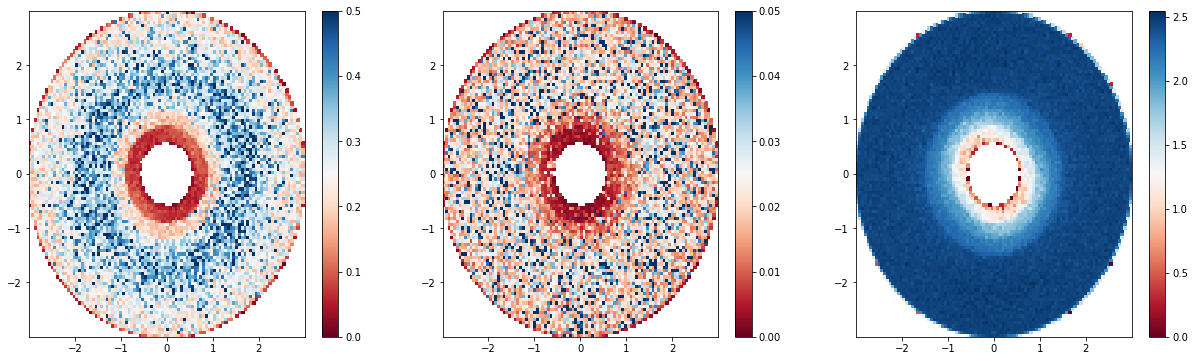

In [923]:
from matplotlib.ticker import FixedLocator, MultipleLocator


fig, ax = plt.subplots(1,3, figsize=(21,6))



h = ax[0].hist2d(xv.flatten(), yv.flatten(), bins=(bin_x, bin_y),  weights=fig_of_merit.flatten()/np.max(fig_of_merit[~np.isnan(fig_of_merit)]) , cmap='RdBu', vmin=0, vmax=0.5);# weights=);
plt.colorbar(h[3], ax=ax[0]);

#h = ax[1].hist2d(xv.flatten(), yv.flatten(), bins=(bin_x, bin_y),  weights=np.log10(hist_count.flatten()) , cmap='RdBu', vmin=-1, vmax=3.5);# weights=);
#h = ax[1].hist2d(xv.flatten(), yv.flatten(), bins=(bin_x, bin_y),  weights=hist_ntimesb.flatten()/np.max(hist_ntimesb[~np.isnan(hist_ntimesb)]) , cmap='RdBu');
#h = ax[1].hist2d(xv.flatten(), yv.flatten(), bins=(bin_x, bin_y),  weights=np.log10(hist_nsq.flatten()/np.max(hist_nsq[~np.isnan(hist_nsq)])) , cmap='RdBu');
#h = ax[1].hist2d(xv.flatten()[hist_nsq.flatten()>1e-18], yv.flatten()[hist_nsq.flatten()>1e-18], bins=(bin_x, bin_y),  weights=np.log10(hist_nsq.flatten()[hist_nsq.flatten()>1e-18]) , cmap='RdBu', vmin=-7, vmax=-3);
#h = ax[1].hist2d(xv.flatten(), yv.flatten(), bins=(bin_x, bin_y),  weights=np.log10(hist_ntimesb.flatten()) , cmap='RdBu', vmin=-5, vmax=-1);
h = ax[1].hist2d(xv.flatten(), yv.flatten(), bins=(bin_x, bin_y),  weights=hist_ntimesb.flatten()/np.max(hist_ntimesb[~np.isnan(hist_ntimesb)]) , cmap='RdBu', vmin=0, vmax=0.05);
plt.colorbar(h[3], ax=ax[1]);

#h = ax[2].hist2d(xv.flatten(), yv.flatten(), bins=(bin_x, bin_y),  weights=(hist_tau/np.sqrt(hist_nsq)).flatten() , cmap='RdBu', vmin=-3, vmax=3);# weights=);
#plt.colorbar(h[3], ax=ax[2]);
#h = ax[2].hist2d(xv.flatten(), yv.flatten(), bins=(bin_x, bin_y),  weights=np.log10(hist_mufg.flatten()/np.max(hist_mufg[~np.isnan(hist_mufg)])) , cmap='RdBu');# weights=);
h = ax[2].hist2d(xv.flatten(), yv.flatten(), bins=(bin_x, bin_y),  weights=np.log10(hist_count.flatten()) , cmap='RdBu');# weights=);
plt.colorbar(h[3], ax=ax[2]);


#ax.axhline(y=0, xmin=0, xmax=1, c='k', linewidth=0.5)
#ax.axvline(x=0, ymin=0, ymax=1, c='k', linewidth=0.5)
#ax.set_xlim(-3.1, 3.1)
#ax.set_ylim(-3.1, 3.1)
#ax.set_ylabel(r'$\vec{\beta}_{i\ell}  \cdot  \hat{\mu}_{\ell}^{\perp} $ [arcsec]')
#ax.set_xlabel(r'$\vec{\beta}_{i\ell} \cdot  \hat{\mu}_{\ell} $ [arcsec]')

#ax.xaxis.set_minor_locator(MultipleLocator(0.3))
#ax.grid(which='major', color='white', linewidth=0.6)
#ax.minorticks_on()


In [264]:
np.min(hist_count), np.max()

(0.0, 5037.0)

In [152]:
hist_ToverN = hist_tau/np.sqrt(hist_nsq)

<ipython-input-152-2f58de6f7020>:1: RuntimeWarning: invalid value encountered in true_divide
  hist_ToverN = hist_tau/np.sqrt(hist_nsq)


In [153]:
np.max(hist_ToverN[~np.isnan(hist_ToverN)]), np.min(hist_ToverN[~np.isnan(hist_ToverN)])

(7.169374359687532, -3.067295245436006)

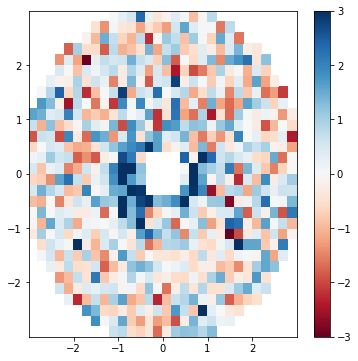

In [154]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

h = ax.hist2d(xv.flatten(), yv.flatten(), bins=(bin_x, bin_y),  weights=hist_ToverN.flatten() , cmap='RdBu', vmin=-3, vmax=3);# weights=);

plt.colorbar(h[3])

<ipython-input-160-b1d8bbe3a663>:3: RuntimeWarning: divide by zero encountered in log10
  h = ax.hist2d(xv.flatten(), yv.flatten(), bins=(bin_x, bin_y),  weights=np.log10(hist_count.flatten()) , cmap='RdBu');# weights=);


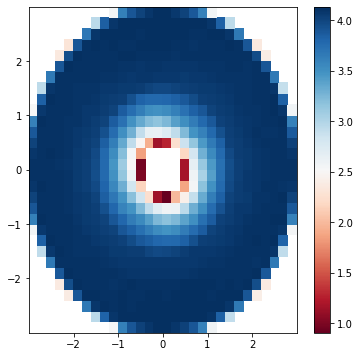

In [160]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

h = ax.hist2d(xv.flatten(), yv.flatten(), bins=(bin_x, bin_y),  weights=np.log10(hist_count.flatten()) , cmap='RdBu');# weights=);

plt.colorbar(h[3])

NameError: name 'cutoff_tau' is not defined

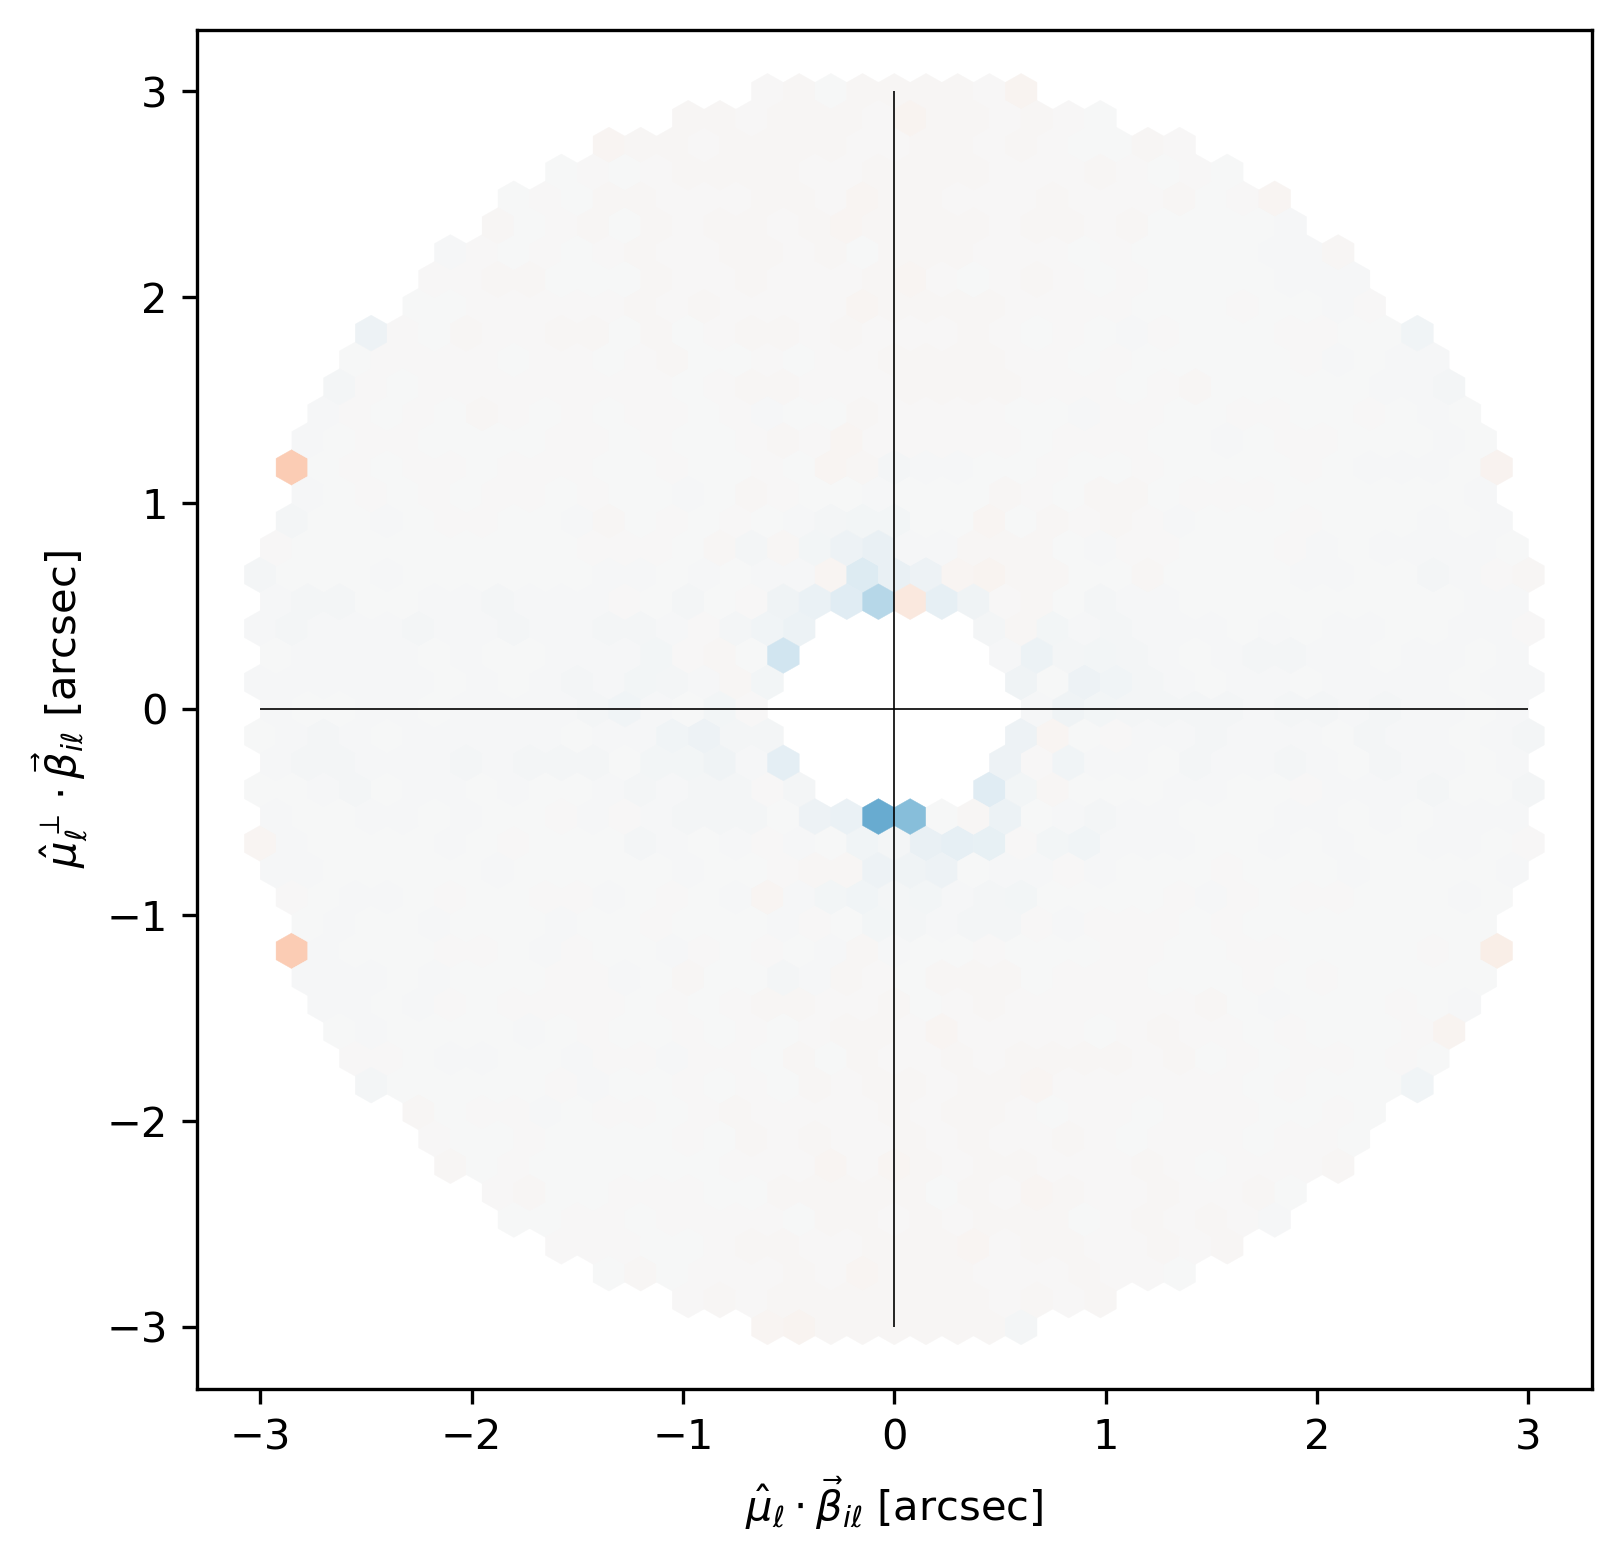

In [78]:
fig, ax = plt.subplots(1,1, figsize=(6,6),dpi=300)

im1 = ax.hexbin(x=df_back.iloc[good_bil_ind]['dotprod_bil'],
                y=df_back.iloc[good_bil_ind]['dotperp_bil'],
                C=tau_mu_list/np.sqrt(tau_norm_sq_list), 
                reduce_C_function = np.mean, 
                vmin = - 3, 
                vmax = 3, 
                gridsize = 40, 
                cmap = 'RdBu',
                linewidths=0.1)

ax.hlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4) 
ax.vlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4)

ax.set_ylabel(r'$\hat{\mu}_{\ell}^{\perp} \cdot \vec{\beta}_{i\ell}$ [arcsec]')
ax.set_xlabel(r'$\hat{\mu}_{\ell} \cdot \vec{\beta}_{i\ell}$ [arcsec]')
#ax.set_title(r'Anisotropy of $\mathcal{T}_\mu/\mathcal{N}$, $|\mathcal{T}/\mathcal{N}|<$ ')


cbar_ax1 = fig.add_axes([1, 0.15, 0.05, 0.7])
cbar1 = fig.colorbar(im1, cax=cbar_ax1)

cbar1.set_label(r'Unweighted Mean $\mathcal{T}_\mu/\mathcal{N}$')

#fig.savefig('anisotropy_plot_tmu.pdf')

# Anisotropy Plots

In [12]:
#Modify template to return list of values
def fn_tau_mu2(df_fore, df_back, weights, tau_obs, tau_max=False, matched_filter = fn_dipole_mf, rot_angle=False, quiet=True):
    """
    For a given data frame of foreground and background stars, return the proper motion tau test statistic and its normalization.
    Weights must be an array of 2x2 matrices of the same lenght of df_fore and df_back, e.g. the pm inverse covariance matrix for each background star.
    If tau_max!=False, only the values of tau < tau_max are kept in the sum over all pairs. 
    """
    
    if not quiet: print('Computing the expected velocity.'); sys.stdout.flush()
    lensing_pm, good_bil_ind = fn_lensing_pm(df_fore['ra'].to_numpy(), df_fore['dec'].to_numpy(),
                                             df_fore['pmra'].to_numpy(),  df_fore['pmdec'].to_numpy(), df_fore['parallax'].to_numpy(),
                                             df_back['ra'].to_numpy(), df_back['dec'].to_numpy(),
                                             df_back['pmra'].to_numpy(), df_back['pmdec'].to_numpy(), df_back['parallax'].to_numpy(), tau_obs, matched_filter)

    if(len(lensing_pm) < len(df_back)):
        if not quiet: print((len(df_back)-len(lensing_pm)), 'star pairs have too small impact parameter. Selecting only the good pairs.'); sys.stdout.flush()
        df_back = df_back.iloc[good_bil_ind]; weights = weights[good_bil_ind]
    
    if rot_angle:
        if not quiet: print('Rotating the dipole profile by', rot_angle/degree, 'deg'); sys.stdout.flush()
        costh, sinth = np.cos(rot_angle), np.sin(rot_angle)
        lensing_pm = np.array([lensing_pm[:,0]*costh-lensing_pm[:,1]*sinth, lensing_pm[:,1]*costh+lensing_pm[:,0]*sinth]).T


    if not quiet: print('Computing the tau lists.'); sys.stdout.flush()
    ### Observed background stars' proper motion (after subtraction)
    observed_pm = np.array([df_back['pmra_sub_new'].to_numpy(), df_back['pmdec_sub_new'].to_numpy()]).T
    tau_norm_sq = weights[:, 0, 0]*lensing_pm[:, 0]**2 + weights[:, 1, 1]*lensing_pm[:, 1]**2 + 2*weights[:, 0, 1]*lensing_pm[:, 0]*lensing_pm[:, 1]
    tau_mu = (weights[:, 0, 0]*lensing_pm[:, 0]*observed_pm[:, 0] + weights[:, 1, 1]*lensing_pm[:, 1]*observed_pm[:, 1] + 
              weights[:, 0, 1]*(lensing_pm[:, 0]*observed_pm[:, 1] + lensing_pm[:, 1]*observed_pm[:, 0]))

    if not quiet: print('Computing the sum.'); sys.stdout.flush()
    if tau_max!=0:
        small_tau_mu = tau_mu[np.abs(tau_mu) < tau_max]
        if not quiet: print(str((1-len(small_tau_mu)/len(tau_mu))*100)+'% of taus removed')
        return small_tau_mu, np.sqrt(tau_norm_sq[np.abs(tau_mu) < tau_max])
    else:
        return tau_mu, np.sqrt(tau_norm_sq)

In [13]:
matched_filter=fn_dipole_mf
_, good_bil_ind = fn_lensing_pm(df_fore['ra'].to_numpy(), df_fore['dec'].to_numpy(),
                                             df_fore['pmra'].to_numpy(),  df_fore['pmdec'].to_numpy(), df_fore['parallax'].to_numpy(),
                                             df_back['ra'].to_numpy(), df_back['dec'].to_numpy(),
                                             df_back['pmra'].to_numpy(), df_back['pmdec'].to_numpy(), df_back['parallax'].to_numpy(), tau_obs, matched_filter)

In [14]:
#drop bad indices in the df
df_fore = df_fore.iloc[good_bil_ind]
df_back = df_back.iloc[good_bil_ind]

## Vector definitions

This section defines the key quantities for vizualisations, like the components of $\boldsymbol{\beta}_{i\ell}$ and $\boldsymbol{\mu}_{\mathrm{bg}}$ along the parallel/perpendicular directions of the foreground star's motion.

In [15]:
fg_ra = df_fore['ra'] 
fg_dec = df_fore['dec']
fg_pmra= df_fore['pmra'] 
fg_pmdec= df_fore['pmdec']


bg_ra = df_back['ra']
bg_dec = df_back['dec'] 
bg_pmra= df_back['pmra_sub_new'] 
bg_pmdec= df_back['pmdec_sub_new'] 

#bil separation vectors
l_bilvec = fn_angular_sep(fg_ra*degree, fg_dec*degree, bg_ra*degree, bg_dec*degree)
l_bilnormsq = l_bilvec[:, 0]**2 + l_bilvec[:, 1]**2

l_bilhat = np.array([l_bilvec[:, 0]/np.sqrt(l_bilnormsq), l_bilvec[:, 1]/np.sqrt(l_bilnormsq)]).T 
l_bilhatperp = np.array([-l_bilhat[:, 1], l_bilhat[:, 0]]).T

#foreground mu vectors
l_muvec = np.array([fg_pmra, fg_pmdec]).T*mas/Year
#l_muvec = np.array([fg_pmra - bg_pmra, fg_pmdec - bg_pmdec]).T*mas/Year


l_munormsq = l_muvec[:, 0]**2 + l_muvec[:, 1]**2
l_muhat = np.array([l_muvec[:, 0]/np.sqrt(l_munormsq), l_muvec[:, 1]/np.sqrt(l_munormsq)]).T 
l_muhatperp = np.array([-l_muhat[:, 1], l_muhat[:, 0]]).T

#project bil onto fg mu
df_back['dotprod_bil'] = (l_bilvec[:,0]*l_muhat[:,0] + l_bilvec[:,1]*l_muhat[:,1])/arcsec
df_back['dotperp_bil'] = (l_bilvec[:,0]*l_muhatperp[:,0] + l_bilvec[:,1]*l_muhatperp[:,1])/arcsec

# bg's motion parallel to and perpendicular to fg's motion
df_back['mu_par'] = (bg_pmra*l_muhat[:,0] + bg_pmdec*l_muhat[:,1])
df_back['mu_perp'] = (bg_pmra*l_muhatperp[:,0] + bg_pmdec*l_muhatperp[:,1])

In [16]:
inv_cov_pm =  np.linalg.inv(fn_cov_pm_eff(df_back))
l_tau_mu, l_tau_mu_norm  = fn_tau_mu2(df_fore, df_back, inv_cov_pm, tau_obs, tau_max=False, matched_filter=fn_dipole_mf, rot_angle=False, quiet=False)

df_back['tau_mu_n'] = l_tau_mu/l_tau_mu_norm

Computing the expected velocity.
Computing the tau lists.
Computing the sum.


## Check the variance, then compute signal after cutting out inner stars

In [20]:
direction = df_back['pmra_sub_new']

bil_bins = np.arange(0, 3., 0.3)
dist_list = np.sqrt(l_bilnormsq)/arcsec
b_list = np.digitize(dist_list, bil_bins)

var_ra = np.zeros(len(bil_bins))

for i_b in tqdm(range(len(bil_bins))):
    direction_i_b = direction[b_list == i_b]
    var_ra[i_b] = np.var(direction_i_b) 

100%|██████████| 10/10 [00:00<00:00, 22.98it/s]


In [21]:
direction = df_back['pmdec_sub_new']

var_dec = np.zeros(len(bil_bins))

for i_b in tqdm(range(len(bil_bins))):
    direction_i_b = direction[b_list == i_b]
    var_dec[i_b] = np.var(direction_i_b) 

100%|██████████| 10/10 [00:00<00:00, 23.02it/s]


In [22]:
direction = df_back['mu_par']

var_par = np.zeros(len(bil_bins))

for i_b in tqdm(range(len(bil_bins))):
    direction_i_b = direction[b_list == i_b]
    var_par[i_b] = np.var(direction_i_b) 

100%|██████████| 10/10 [00:00<00:00, 22.63it/s]


In [23]:
direction = df_back['mu_perp']

var_perp = np.zeros(len(bil_bins))

for i_b in tqdm(range(len(bil_bins))):
    direction_i_b = direction[b_list == i_b]
    var_perp[i_b] = np.var(direction_i_b) 

100%|██████████| 10/10 [00:00<00:00, 22.23it/s]


In [24]:
np.bincount(b_list)

array([      0,       0,     300,   51013,  231765,  576272, 1064142,
       1332117, 1615572, 1835765, 2056175])

In [25]:
eff_pmra = df_back['pmra_eff_error_new']
eff_pmdec = df_back['pmdec_eff_error_new']

var = np.zeros(len(bil_bins))

for i_b in tqdm(range(len(bil_bins))):
    eff_pmra_i_b = eff_pmra[b_list == i_b]
    eff_pmdec_i_b = eff_pmdec[b_list == i_b]
    var[i_b] = np.mean(eff_pmra_i_b**2 + eff_pmdec_i_b**2)

100%|██████████| 10/10 [00:00<00:00, 11.38it/s]


In [26]:
var_perp

array([       nan,        nan, 6.59376559, 5.57891859, 4.4201613 ,
       4.10071028, 4.07037296, 4.05982174, 4.04293538, 4.02318228])

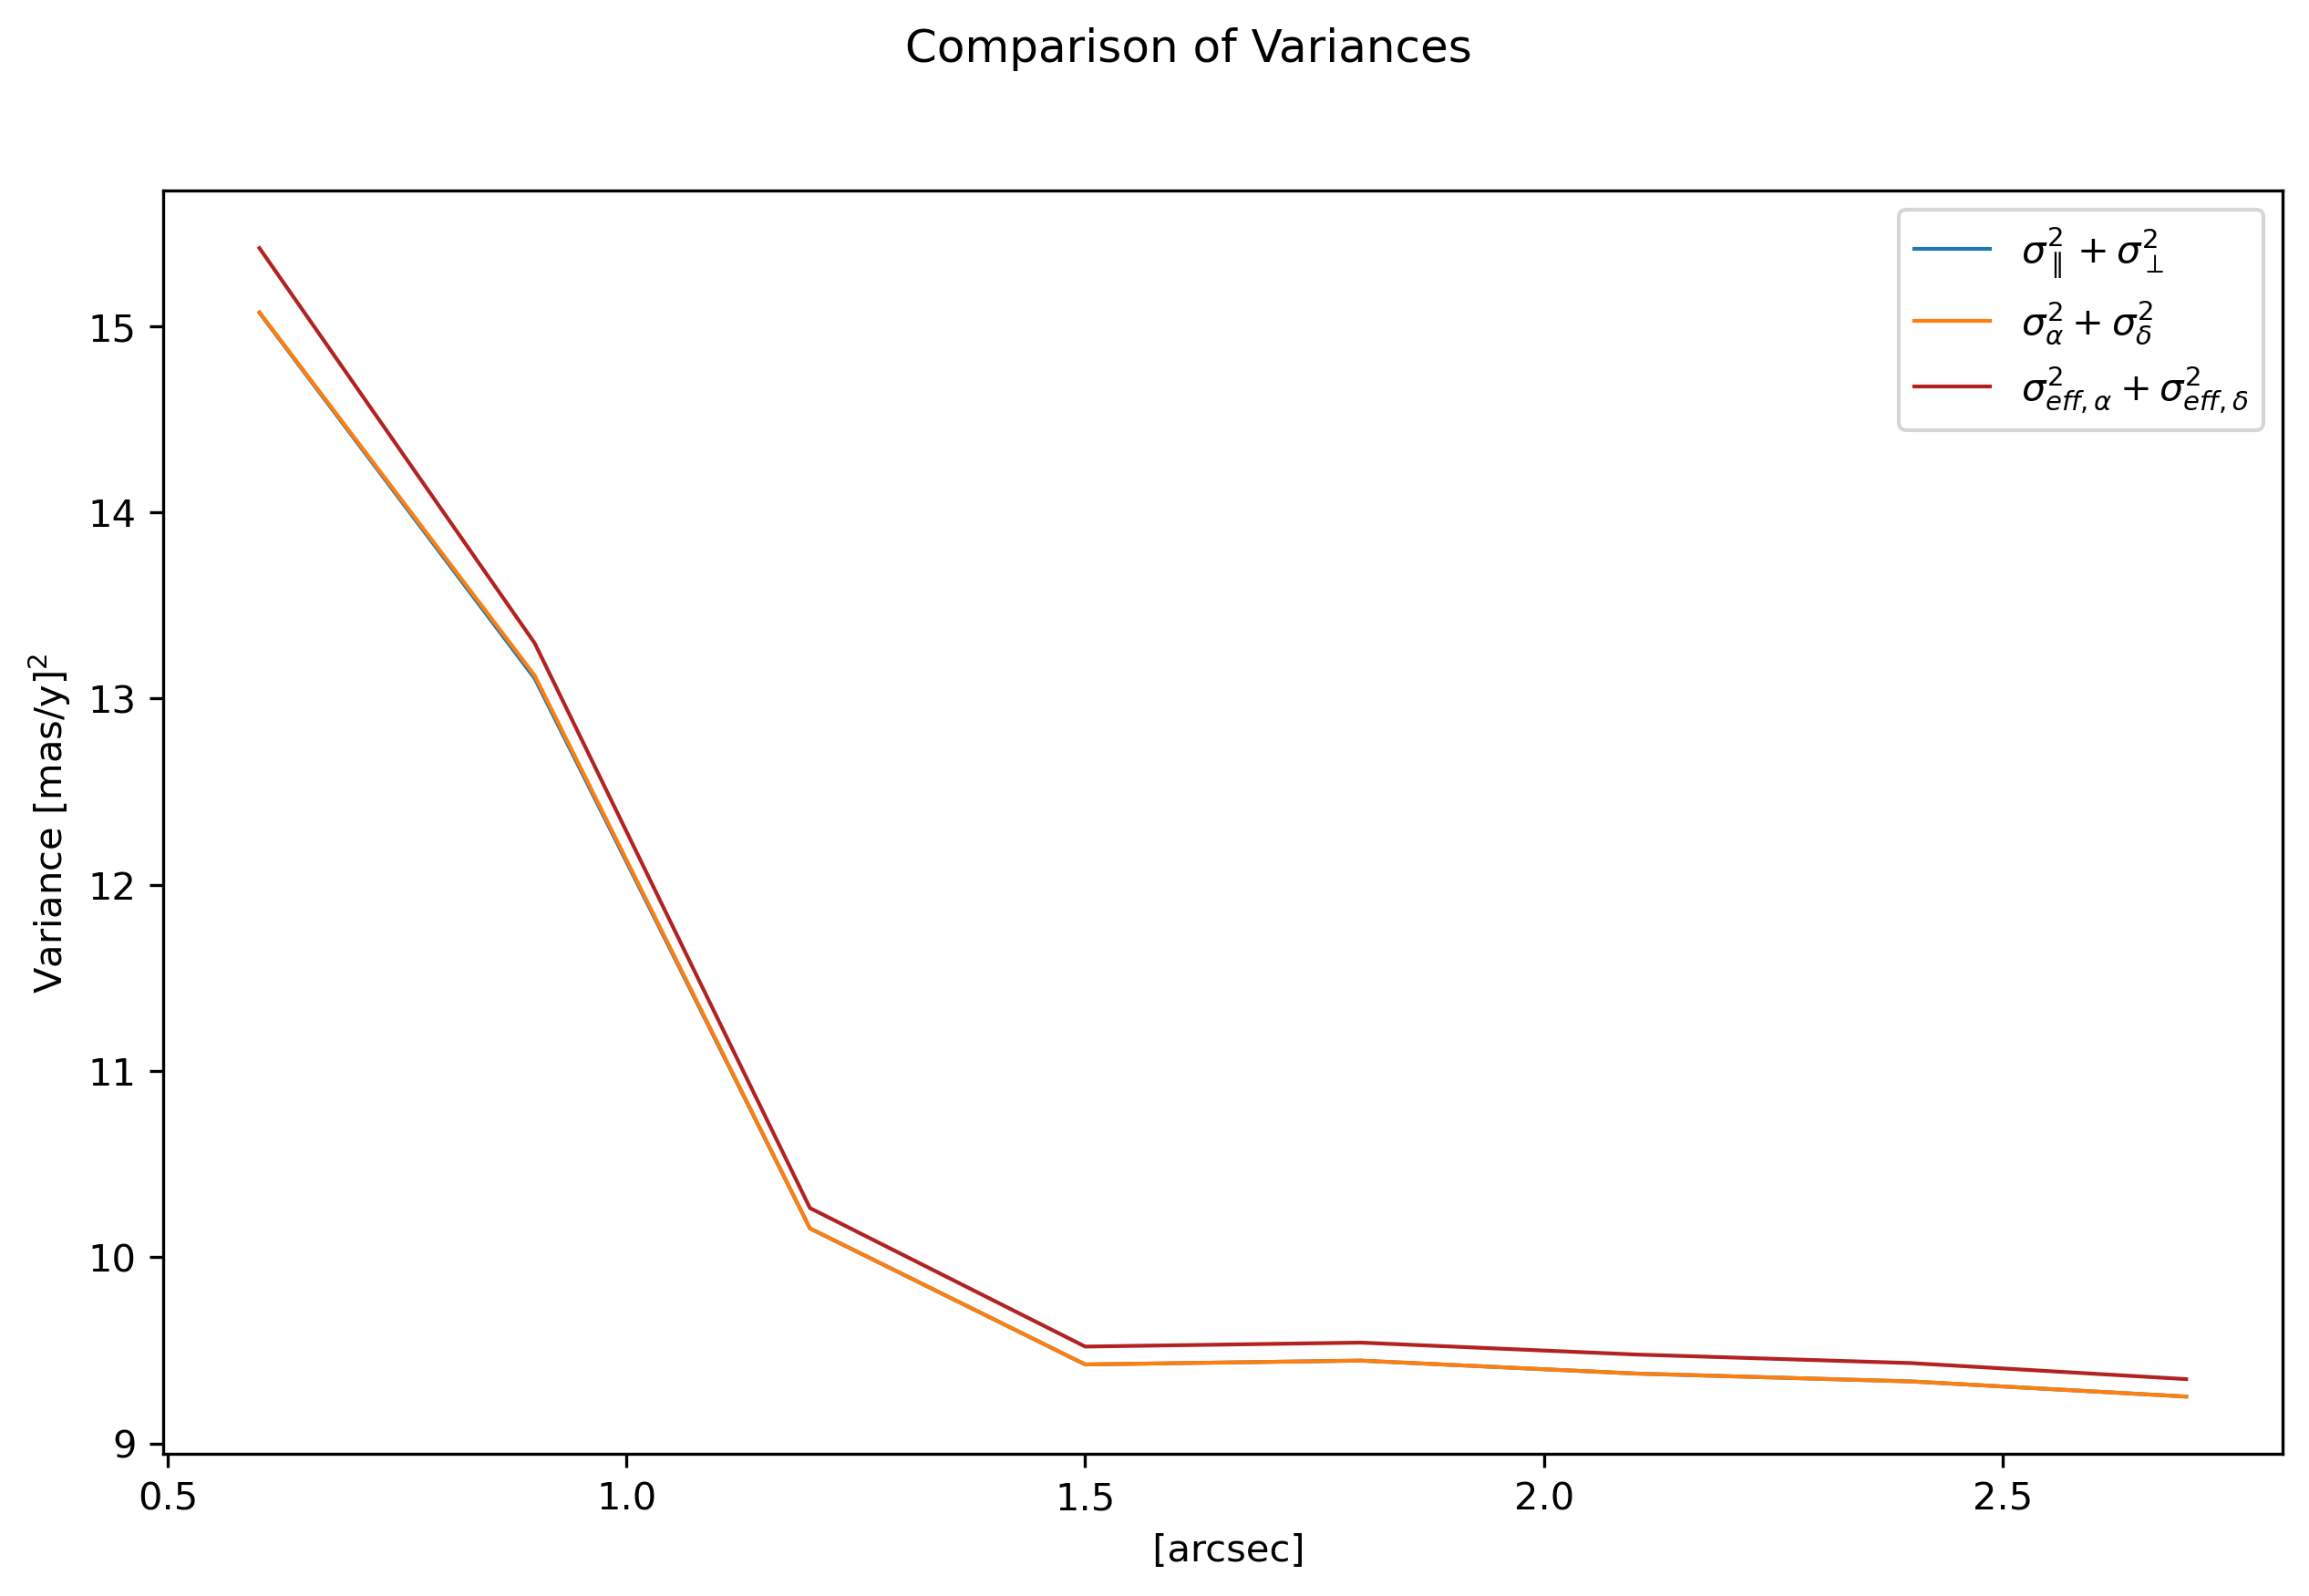

In [27]:
fig, ax = plt.subplots(1,1, figsize=(10,6),dpi=300)
ax.plot(bil_bins, var_par + var_perp, label = r'$\sigma_{\parallel}^2 + \sigma_{\perp}^2$', lw = 1)
ax.plot(bil_bins, var_ra + var_dec, label = r'$\sigma_{\alpha}^2 + \sigma_{\delta}^2$', lw = 1)
ax.plot(bil_bins, var, label = r'$\sigma_{eff, \alpha}^2 + \sigma_{eff,\delta}^2$', lw = 1, color = 'firebrick')
ax.set_ylabel(r'Variance [mas/y]$^2$')
ax.set_xlabel(r' [arcsec]')
fig.suptitle('Comparison of Variances')
ax.legend()

In [127]:
### cut out stars < min_radius
cutoff_tau = 3
min_radius = 0.0

condition1 = np.abs(l_tau_mu/l_tau_mu_norm) < cutoff_tau
condition2 = np.sqrt(l_bilnormsq)/arcsec > min_radius

df_backsmaller = df_back[condition1 & condition2]
df_foresmaller = df_fore[condition1 & condition2]
l_bilnormsq_smaller = l_bilnormsq[condition1 & condition2]
len(df_backsmaller), len(df_backsmaller)/len(df_back)

ValueError: operands could not be broadcast together with shapes (8763121,) (8711533,) 

In [64]:
inv_cov_pm = np.linalg.inv(fn_cov_pm_eff(df_backsmaller)) # np.linalg.inv(fn_cov_pm_new(df_foresmaller, df_backsmaller))
tau_mu, tau_norm_sq = fn_tau_mu(df_foresmaller, df_backsmaller, inv_cov_pm, tau_obs, tau_max=False, matched_filter=fn_dipole_mf, rot_angle=False, quiet=False)

Computing the expected velocity.
Computing the tau lists.
Computing the sum.


In [65]:
print('T   : ' + str(tau_mu))
print('N   : ' + str(tau_norm_sq))
print('T/N : ' + str(tau_mu/tau_norm_sq))

T   : 1.137520817701379
N   : 0.3720533199098408
T/N : 3.0574134319700006


In [66]:
#del df_back; del df_fore

## Anisotropy (unit $\mu$)

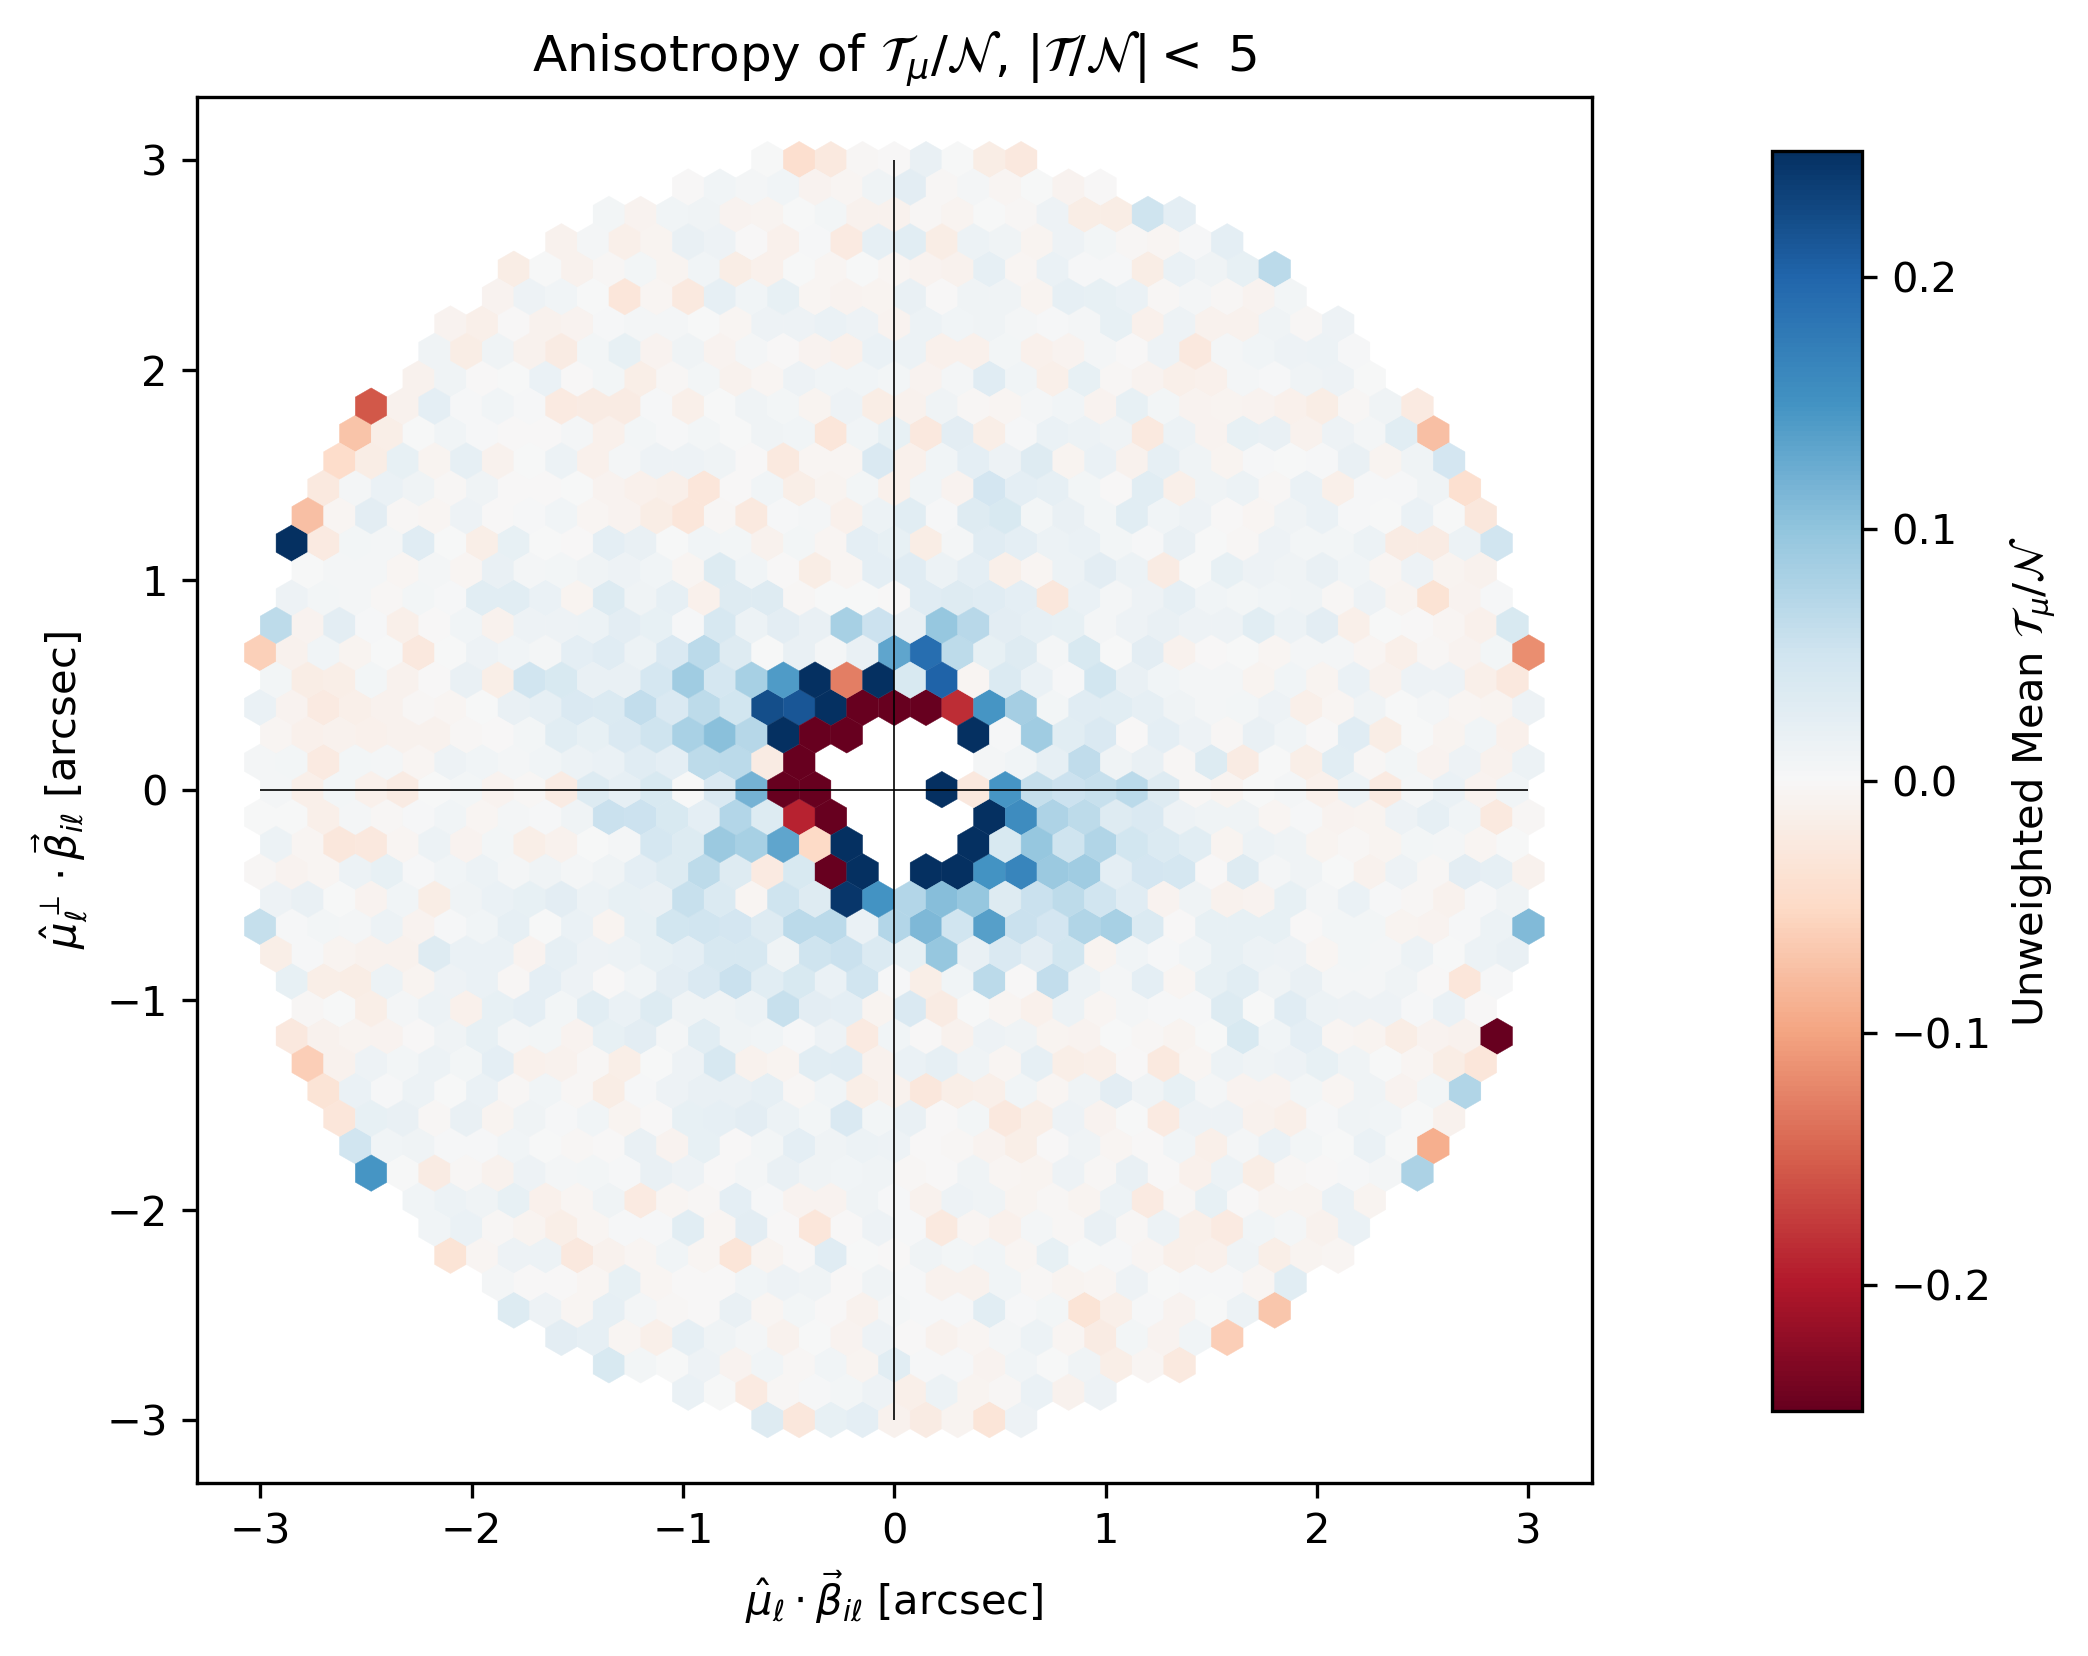

In [40]:
fig, ax = plt.subplots(1,1, figsize=(6,6),dpi=300)

im1 = ax.hexbin(x=df_backsmaller['dotprod_bil'],
                y=df_backsmaller['dotperp_bil'],
                C=df_backsmaller['tau_mu_n'], 
                reduce_C_function = np.mean, 
                vmin = - 0.05* cutoff_tau, 
                vmax = 0.05 * cutoff_tau, 
                gridsize = 40, 
                cmap = 'RdBu',
                linewidths=0.1)

ax.hlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4) 
ax.vlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4)

ax.set_ylabel(r'$\hat{\mu}_{\ell}^{\perp} \cdot \vec{\beta}_{i\ell}$ [arcsec]')
ax.set_xlabel(r'$\hat{\mu}_{\ell} \cdot \vec{\beta}_{i\ell}$ [arcsec]')
ax.set_title(r'Anisotropy of $\mathcal{T}_\mu/\mathcal{N}$, $|\mathcal{T}/\mathcal{N}|<$ ' + str(cutoff_tau))


cbar_ax1 = fig.add_axes([1, 0.15, 0.05, 0.7])
cbar1 = fig.colorbar(im1, cax=cbar_ax1)

cbar1.set_label(r'Unweighted Mean $\mathcal{T}_\mu/\mathcal{N}$')

#fig.savefig('anisotropy_plot_tmu.pdf')

# Proper motion distributions

In [45]:
fg_pmra = df_fore['pmra']
fg_pmdec = df_fore['pmdec']
fg_pmra_err = df_fore['pmra_error']
fg_pmdec_err = df_back['pmdec_error']
(np.average(fg_pmra, weights=1/fg_pmra_err**2), np.average(fg_pmdec, weights=1/fg_pmdec_err**2))

(-4.001569694147646, -3.51482577386855)

In [46]:
bg_pmra = df_back['pmra_sub']
bg_pmdec = df_back['pmdec_sub']

np.cov(bg_pmra, bg_pmdec)

array([[4.47289448, 1.18610646],
       [1.18610646, 4.77310608]])

In [47]:
fg_pm_mag = np.sqrt(df_foresmaller['pmra']**2 + df_foresmaller['pmdec']**2)
bg_pm_mag = np.sqrt(df_backsmaller['pmra_sub_new']**2 + df_backsmaller['pmdec_sub_new']**2)

fg_parallax = np.asarray(df_foresmaller['parallax'])

In [48]:
fg_pm_error = np.sqrt(df_foresmaller['pmra_error']**2 + df_foresmaller['pmdec_error']**2)
bg_pm_error = np.sqrt(df_backsmaller['pmra_error']**2 + df_backsmaller['pmdec_error']**2)

In [49]:
mu_min = 0
mu_max = 10000

condition = (fg_pm_mag < mu_max) & (fg_pm_mag > mu_min)
df_back1 =  df_backsmaller[condition]
df_fore1 =  df_foresmaller[condition]
l_bilnormsq1 = l_bilnormsq_smaller[condition]

fg_pm_mag1 = np.sqrt(df_fore1['pmra']**2 + df_fore1['pmdec']**2)
len(df_fore1)

8283937

In [50]:
cutoff_mu = 1

df_backfar = df_back1[np.sqrt(l_bilnormsq1)/arcsec > 1.5]
far_mean = np.mean(df_backfar['pmra_sub_new']); print(far_mean)

-0.0011961182748340792


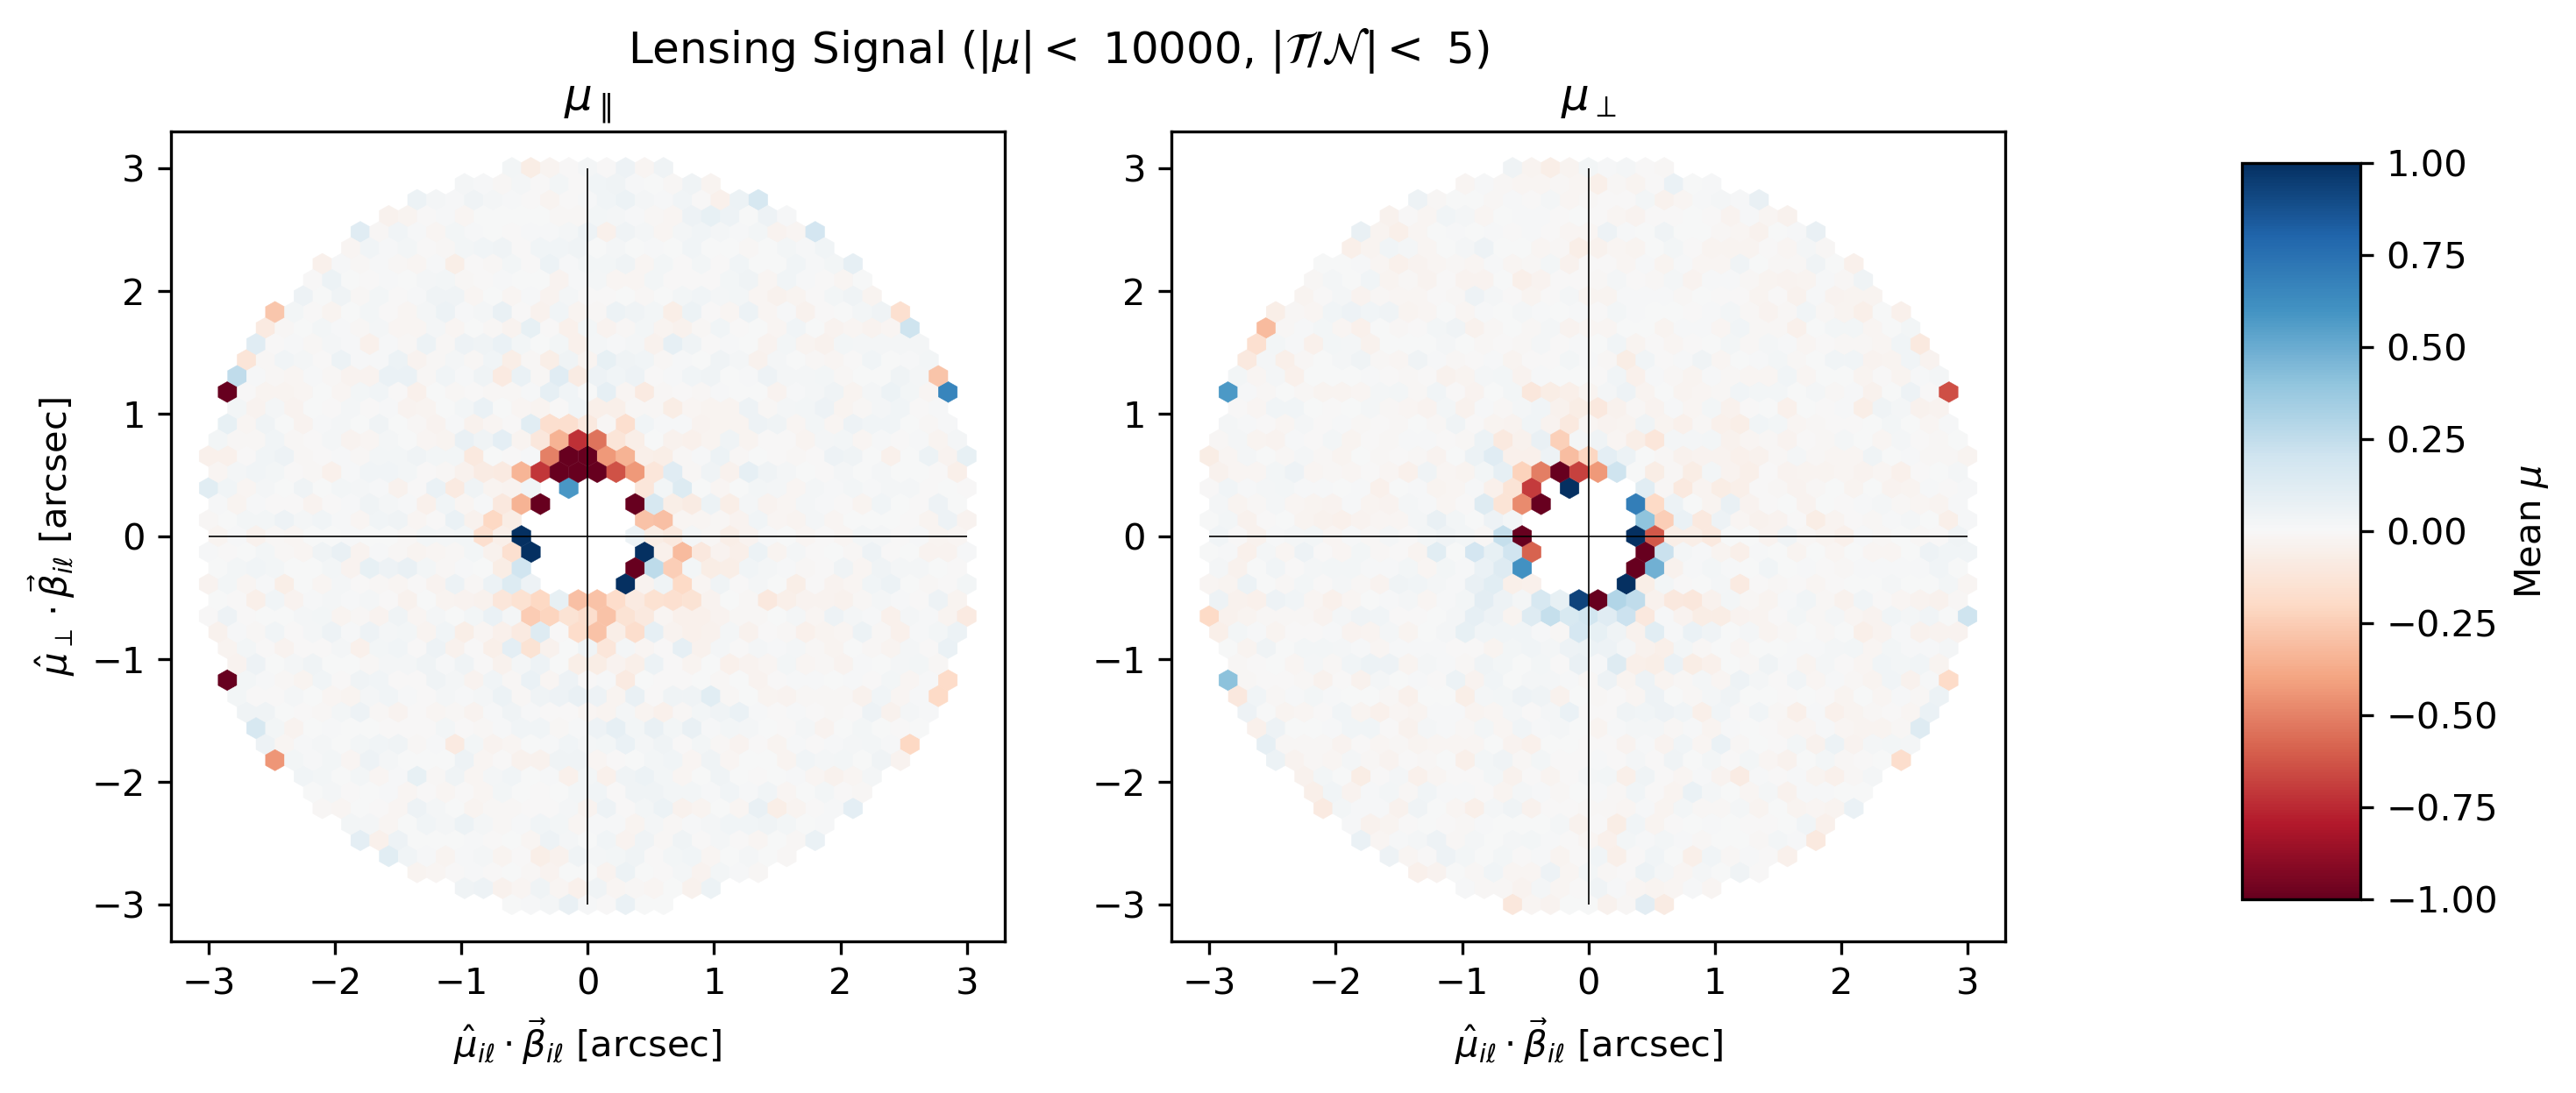

In [51]:
fig, ax = plt.subplots(1,2, figsize=(9,4),dpi=300)

im1 = ax[0].hexbin(x=df_back1['dotprod_bil'], y=df_back1['dotperp_bil'], C=(df_back1['mu_par']), reduce_C_function = np.mean, vmin = -cutoff_mu, vmax = cutoff_mu, gridsize=40, cmap = 'RdBu',linewidths=0.1)
ax[0].set_ylabel(r'$\hat{\mu}_{\perp} \cdot \vec{\beta}_{i\ell}$ [arcsec]')
ax[0].set_xlabel(r'$\hat{\mu}_{i\ell} \cdot \vec{\beta}_{i\ell}$ [arcsec]')
ax[0].set_title(r'$\mu_\parallel$')

ax[0].hlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4) 
ax[0].vlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4);

#cbar_ax1 = fig.add_axes([-.05, 0.15, 0.05, 0.7])
cbar_ax1 = fig.add_axes([1, 0.15, 0.05, 0.7])
cbar1 = fig.colorbar(im1, cax=cbar_ax1)
#cbar2 = fig.colorbar(im2, cax=cbar_ax2)


cbar1.set_label(r'Mean $\mu$')
#cbar2.set_label(r'Mean fg $\varpi/\sigma_\varpi$')


im2 = ax[1].hexbin(x=df_back1['dotprod_bil'], y=df_back1['dotperp_bil'], C=(np.asarray(df_back1['mu_perp'])), reduce_C_function = np.mean, vmin = -cutoff_mu, vmax = cutoff_mu, gridsize=40, cmap = 'RdBu',linewidths=0.1)
#ax[1].set_ylabel(r'$\hat{\mu}_{\perp} \cdot \vec{\beta}_{i\ell}$ [arcsec]')
ax[1].set_xlabel(r'$\hat{\mu}_{i\ell} \cdot \vec{\beta}_{i\ell}$ [arcsec]')
ax[1].set_title(r'$\mu_\perp$')

ax[1].hlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4) 
ax[1].vlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4)

#cbar_ax1 = fig.add_axes([-.05, 0.15, 0.05, 0.7])
#cbar_ax2 = fig.add_axes([1, 0.15, 0.05, 0.7])
#cbar2 = fig.colorbar(im2, cax=cbar_ax2)
#cbar2 = fig.colorbar(im2, cax=cbar_ax2)


cbar1.set_label(r'Mean $\mu$')
#cbar2.set_label(r'Mean fg $\varpi/\sigma_\varpi$')
fig.suptitle(r'Lensing Signal ($|\mu| <$ ' + str(mu_max) + r', $|\mathcal{T}/\mathcal{N}| <$ ' + str(cutoff_tau) + ')')
fig.show()
#fig.savefig('lensing_signal.pdf')

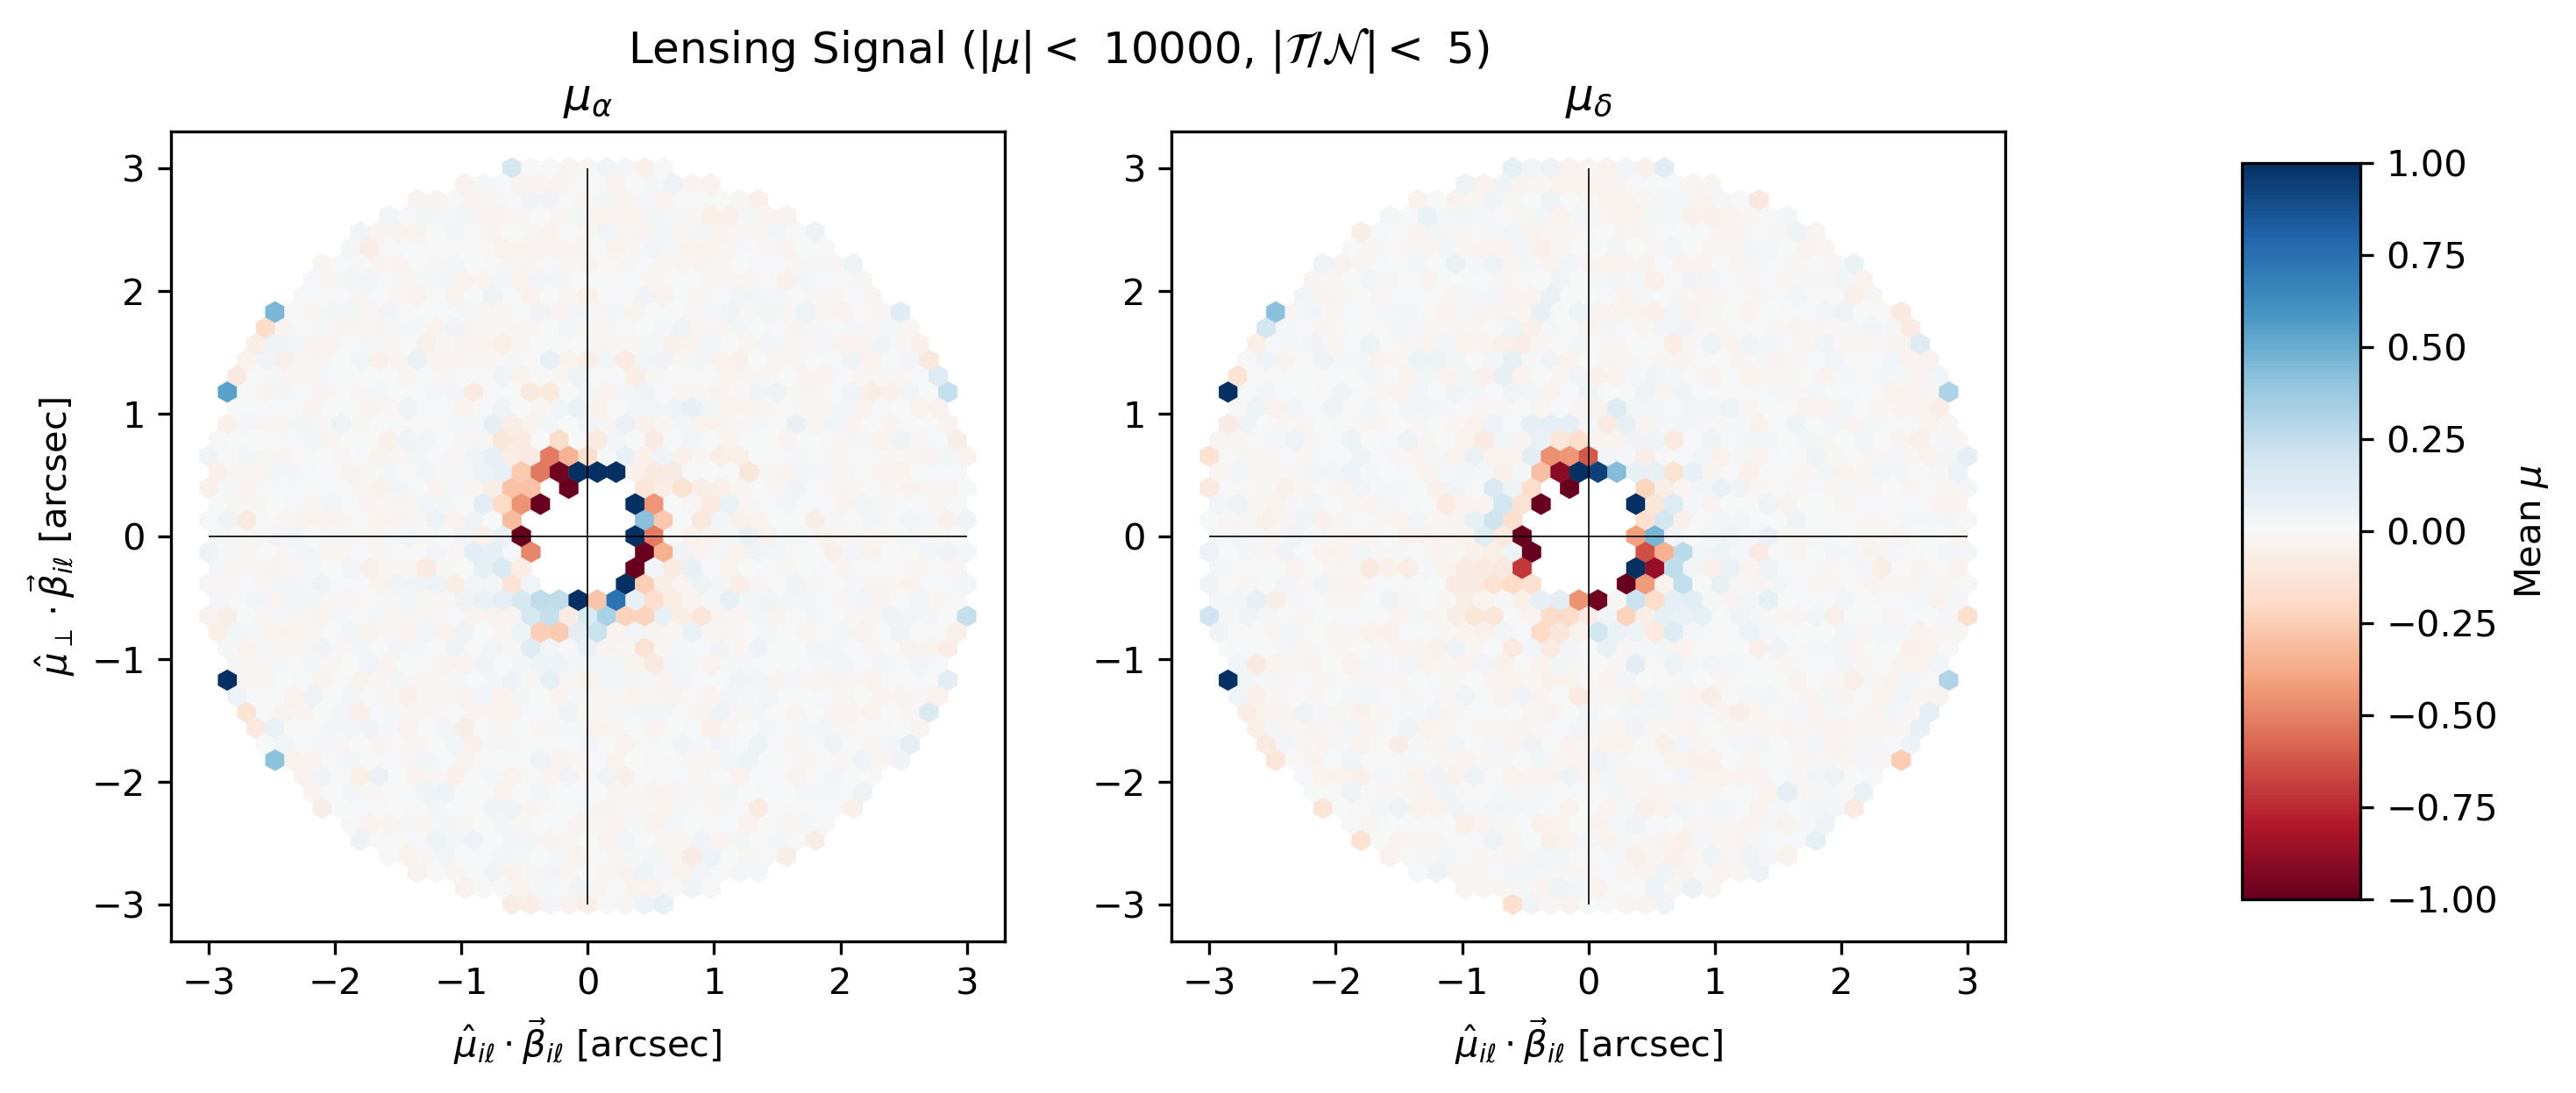

In [52]:
fig, ax = plt.subplots(1,2, figsize=(9,4),dpi=300)

im1 = ax[0].hexbin(x=df_back1['dotprod_bil'], y=df_back1['dotperp_bil'], C=(df_back1['pmra_sub_new']), reduce_C_function = np.mean, vmin = -cutoff_mu, vmax = cutoff_mu, gridsize=40, cmap = 'RdBu',linewidths=0.1)
ax[0].set_ylabel(r'$\hat{\mu}_{\perp} \cdot \vec{\beta}_{i\ell}$ [arcsec]')
ax[0].set_xlabel(r'$\hat{\mu}_{i\ell} \cdot \vec{\beta}_{i\ell}$ [arcsec]')
ax[0].set_title(r'$\mu_\alpha$')

ax[0].hlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4) 
ax[0].vlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4);

#cbar_ax1 = fig.add_axes([-.05, 0.15, 0.05, 0.7])
cbar_ax1 = fig.add_axes([1, 0.15, 0.05, 0.7])
cbar1 = fig.colorbar(im1, cax=cbar_ax1)
#cbar2 = fig.colorbar(im2, cax=cbar_ax2)


cbar1.set_label(r'Mean $\mu$')
#cbar2.set_label(r'Mean fg $\varpi/\sigma_\varpi$')


im2 = ax[1].hexbin(x=df_back1['dotprod_bil'], y=df_back1['dotperp_bil'], C=(np.asarray(df_back1['pmdec_sub_new'])), reduce_C_function = np.mean, vmin = -cutoff_mu, vmax = cutoff_mu, gridsize=40, cmap = 'RdBu',linewidths=0.1)
#ax[1].set_ylabel(r'$\hat{\mu}_{\perp} \cdot \vec{\beta}_{i\ell}$ [arcsec]')
ax[1].set_xlabel(r'$\hat{\mu}_{i\ell} \cdot \vec{\beta}_{i\ell}$ [arcsec]')
ax[1].set_title(r'$\mu_\delta$')

ax[1].hlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4) 
ax[1].vlines(0, -3, 3, colors='k', linestyles='solid', linewidth=0.4)

#cbar_ax1 = fig.add_axes([-.05, 0.15, 0.05, 0.7])
#cbar_ax2 = fig.add_axes([1, 0.15, 0.05, 0.7])
#cbar2 = fig.colorbar(im2, cax=cbar_ax2)
#cbar2 = fig.colorbar(im2, cax=cbar_ax2)


cbar1.set_label(r'Mean $\mu$')
#cbar2.set_label(r'Mean fg $\varpi/\sigma_\varpi$')
fig.suptitle(r'Lensing Signal ($|\mu| <$ ' + str(mu_max) + r', $|\mathcal{T}/\mathcal{N}| <$ ' + str(cutoff_tau) + ')')
fig.show()
#fig.savefig('lensing_signal.pdf')

## Mean PM in radial bins

In [41]:
l_mean_pmra_sub = np.zeros(len(bil_bins))
l_mean_pmdec_sub = np.zeros(len(bil_bins))

In [42]:
### Impact parameter and unit vector in the direction of the impact parameter
b_il = fn_angular_sep(df_fore['ra'].to_numpy()*degree, df_fore['dec'].to_numpy()*degree, 
                      df_back['ra'].to_numpy()*degree, df_back['dec'].to_numpy()*degree)
b_il_norm = np.sqrt(b_il[:, 0]**2 + b_il[:, 1]**2)


bil_bins = np.arange(0.6, 3., 0.2)
print(bil_bins)

dist_list = b_il_norm/arcsec; print(dist_list)
b_list = np.digitize(dist_list, bil_bins); np.bincount(b_list)

[0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8]
[1.78973177 2.80396513 2.28992809 ... 2.85387801 1.98291534 2.16848257]


array([    816,   43645,  121917,  237360,  398361,  638541,  832382,
        943438, 1079151, 1193528, 1292866, 1388579, 1488168])

In [43]:
cov_pm = fn_cov_pm_eff(df_back)

In [44]:
#mean_parallel = np.zeros(len(bil_bins))
#mean_perp = np.zeros(len(bil_bins))

mean_old = np.zeros(len(bil_bins))
mean_new = np.zeros(len(bil_bins))
errbars = np.zeros(len(bil_bins))

#mu_par = #df_back['mu_par'].values
#mu_perp = #df_back['mu_perp'].values

mean_parallel = np.zeros(len(bil_bins))
mean_perp = np.zeros(len(bil_bins))

old_sub_pmra = df_back['pmra_sub']
#old_sub_pmdec = df_back['pmdec_sub']

new_sub_pmra = df_back['pmra_sub_new']
#new_sub_pmdec = df_back['pmdec_sub_new']


pmra_eff_err = np.sqrt(cov_pm[:, 0, 0]) #df_back['pmra_eff_error'].values
pmdec_eff_err = np.sqrt(cov_pm[:, 1, 1])#df_back['pmdec_eff_error'].values

In [45]:
for i_b in tqdm(range(len(bil_bins))):
    mu_old_i_b = old_sub_pmra[b_list == i_b]
    mu_new_i_b = new_sub_pmra[b_list == i_b]

    pmra_eff_err_i_b = pmra_eff_err[b_list == i_b]
    pmdec_eff_err_i_b = pmdec_eff_err[b_list == i_b]

    # weights
    d_wt = np.asarray(1/(pmra_eff_err_i_b**2 + pmdec_eff_err_i_b**2))
    ebar = np.sqrt((1/len(d_wt)**2) * np.sum(1/d_wt))


    # compute averages
    mean_old_i_b = np.average(mu_old_i_b, weights = d_wt)
    mean_new_i_b = np.average(mu_new_i_b, weights = d_wt)

    mean_old[i_b] = mean_old_i_b
    mean_new[i_b] = mean_new_i_b
    errbars[i_b] = ebar

100%|██████████| 12/12 [00:02<00:00,  5.41it/s]


In [46]:
mean_parallel

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [47]:
mean_perp

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

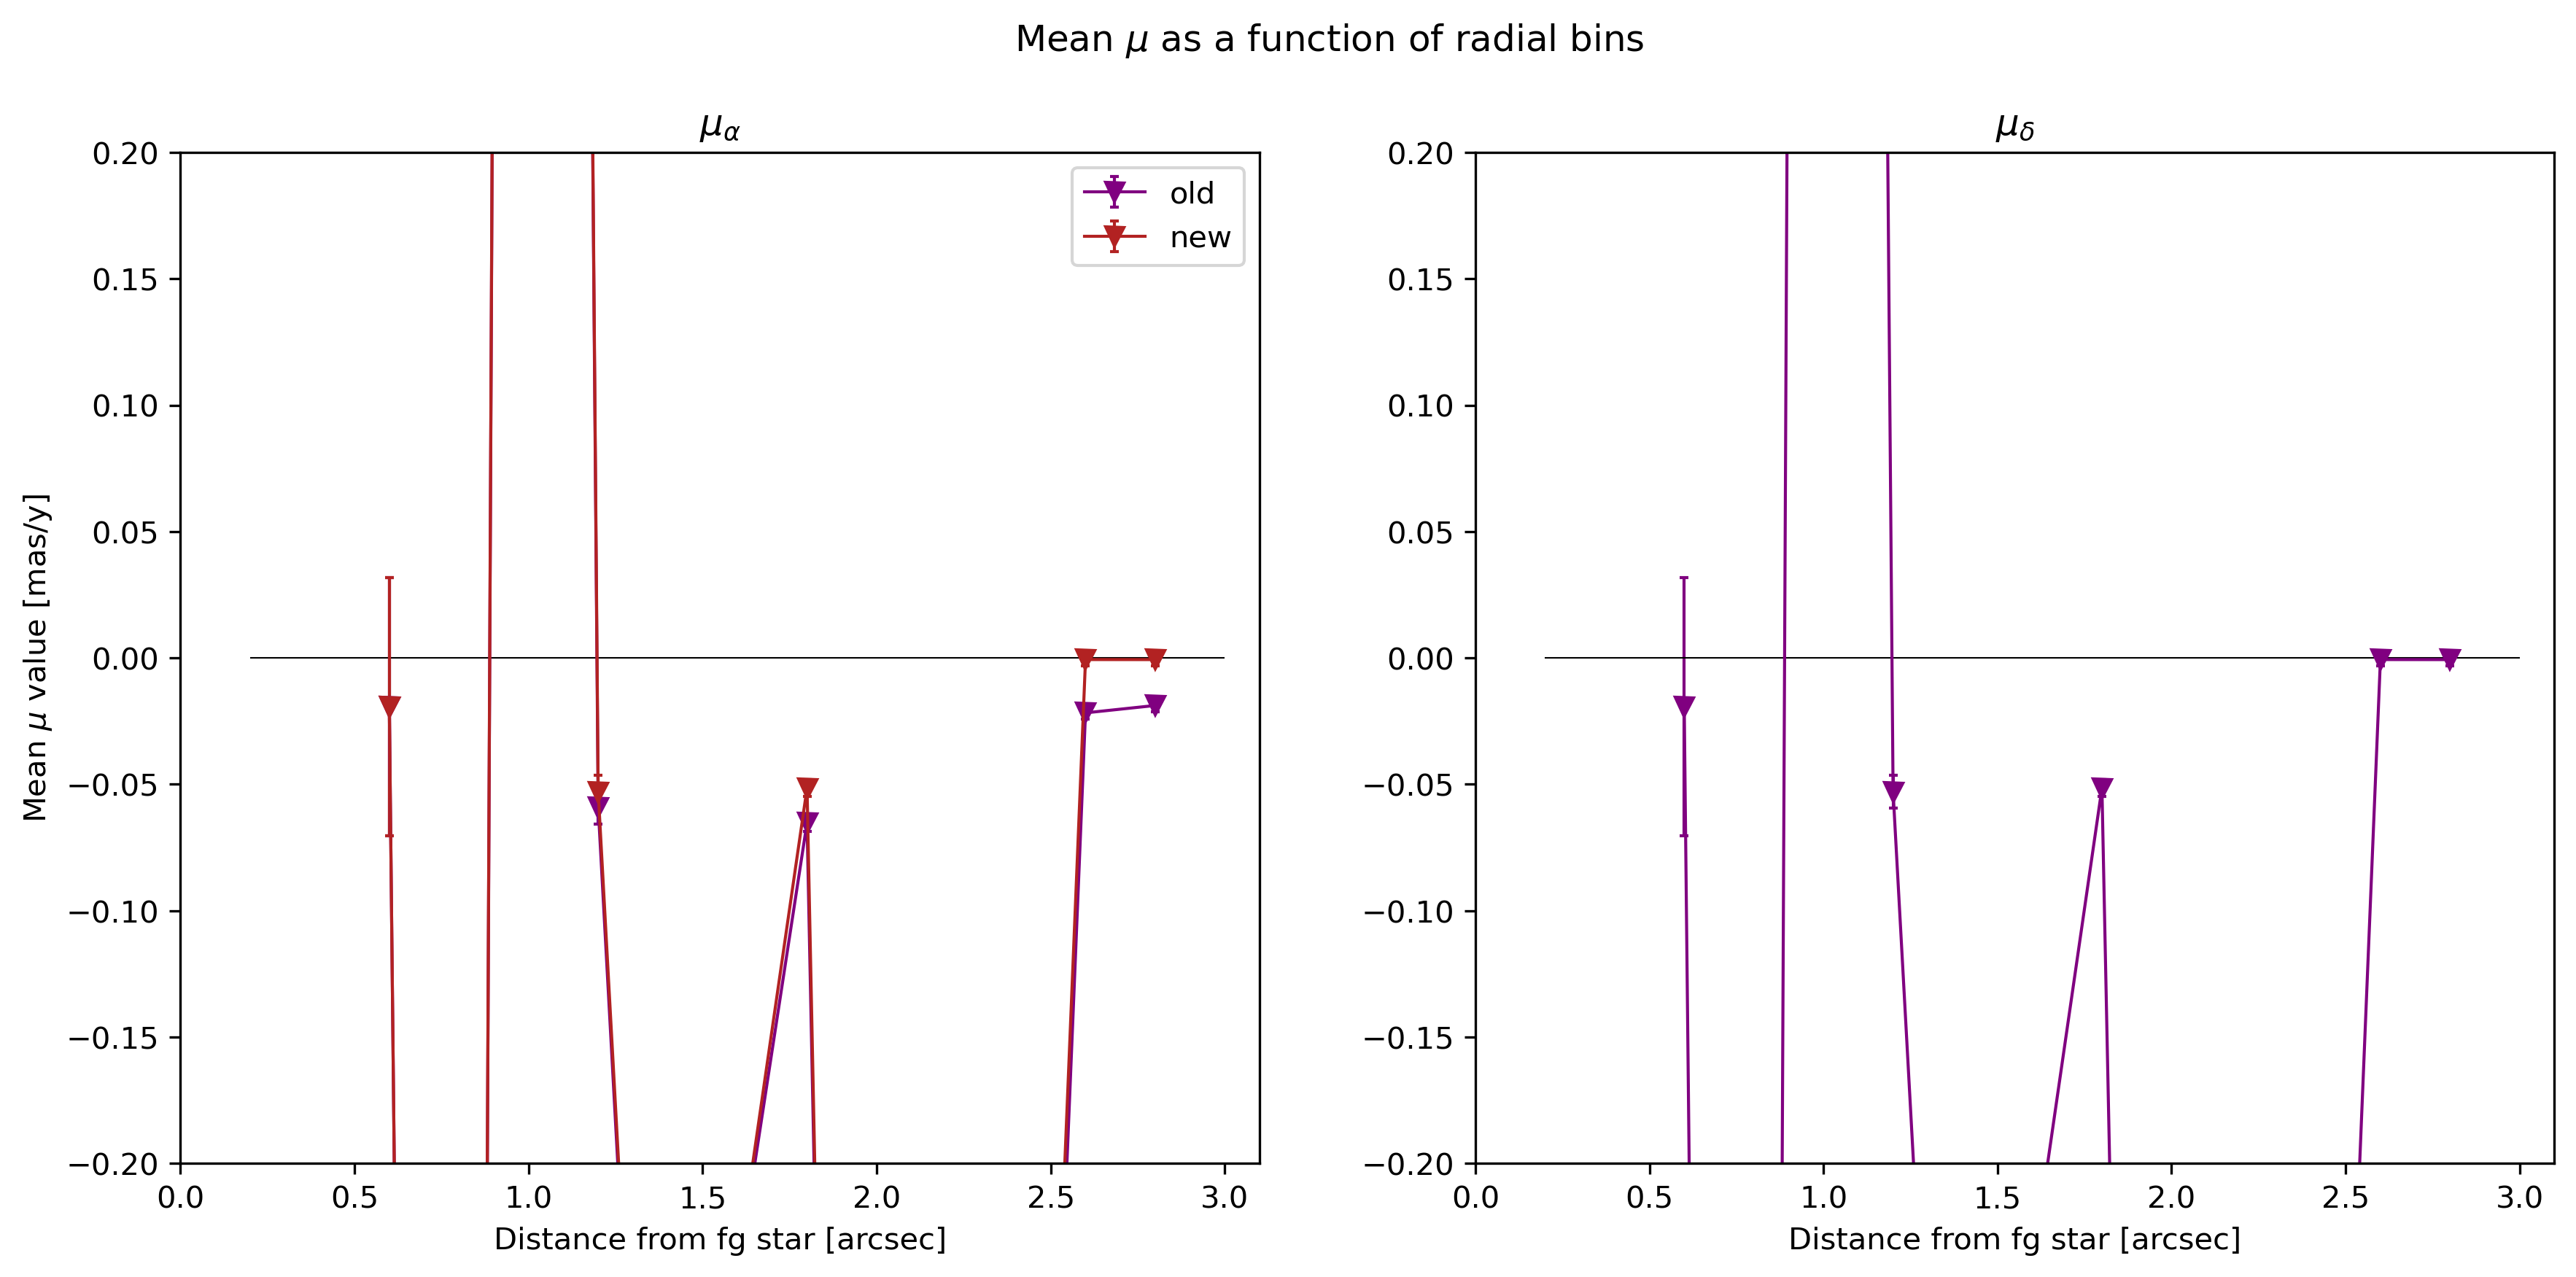

In [48]:
fig, ax = plt.subplots(1,2, figsize=(14,6),dpi=300)
ax[0].errorbar(bil_bins, mean_old, yerr = errbars, marker = 'v', label = 'old', color = 'purple', 
            elinewidth= 1, capsize = 1.5,
            lw= 1)

ax[0].set_ylabel(r'Mean $\mu$ value [mas/y]')
ax[0].set_xlabel(r'Distance from fg star [arcsec]')
ax[0].set_title(r'$\mu_\alpha$')


#ax[0].legend()
ax[0].hlines(0, 0.2, 3, colors='k', linestyles='solid', linewidth=0.5) 
ax[0].set_xlim(0, 3.1)
ax[0].set_ylim(-0.2,0.2)

ax[0].errorbar(bil_bins, mean_new, yerr = errbars, marker = 'v', label = 'new', color = 'firebrick', 
            elinewidth= 1, capsize = 1.5,
            lw= 1)

ax[0].legend()

ax[1].errorbar(bil_bins, mean_new, yerr = errbars, marker = 'v', label = 'Measured', color = 'purple', 
            elinewidth= 1, capsize = 1.5,
            lw= 1)

ax[1].set_xlabel(r'Distance from fg star [arcsec]')
ax[1].set_title(r'$\mu_\delta$')

#ax[1].legend()
ax[1].hlines(0, 0.2, 3, colors='k', linestyles='solid', linewidth=0.5) 
ax[1].set_xlim(0, 3.1)
ax[1].set_ylim(-0.2,0.2)
fig.suptitle(r'Mean $\mu$ as a function of radial bins')
fig.show()

# G-magnitude dependence

In [74]:
G_bins = np.array([5, 15, 16, 17, 17.5, 17.9, 18.3, 18.6, 18.8, 18.95, 19.1, 19.2, 19.3, 19.4, 19.5, 19.6, 19.7, 19.8, 19.9, 20, 20.1, 20.2, 20.3, 20.4, 20.5, 20.6, 20.72, 22])
q_G = np.digitize(df_foresmaller['phot_g_mean_mag'], G_bins)-1
df_foresmaller['q_G'] = q_G
df_backsmaller['q_G'] = q_G
print(G_bins[q_G])

[15.  19.2  5.  ...  5.  19.9  5. ]


/tmp/ipykernel_1834950/1644630271.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_foresmaller['q_G'] = q_G
/tmp/ipykernel_1834950/1644630271.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_backsmaller['q_G'] = q_G


In [75]:
G_count = np.bincount(df_foresmaller['q_G'])
print(len(G_count), len(bil_bins), sum(G_count))

28 28 8711533


In [76]:
df_foreground = df_foresmaller.sort_values(by=['q_G'], ascending=True)
df_background = df_backsmaller.sort_values(by=['q_G'], ascending=True)
df_foreground['q_G']

8763141     0
751676      0
751677      0
5299702     0
751681      0
           ..
1176578    27
6330598    27
8429893    27
4149384    27
2523886    27
Name: q_G, Length: 8711533, dtype: int64

In [78]:
tau_mu_list, tau_norm_list = np.zeros(len(G_count)), np.zeros(len(G_count))
tau_rot90_list, tau_norm_rot90_list = np.zeros(len(G_count)), np.zeros(len(G_count))
tau_monopole_list, tau_norm_monopole_list = np.zeros(len(G_count)), np.zeros(len(G_count))
tau_quad_list, tau_norm_quad_list = np.zeros(len(G_count)), np.zeros(len(G_count))
gmag_mean = np.zeros(len(G_count))

last = 0
for i in tqdm(range(len(G_count))):
    df_fore_sub = df_foreground.iloc[last:last+G_count[i]] 
    df_back_sub = df_background.iloc[last:last+G_count[i]]
    last += G_count[i]
    
    gmag_mean[i] = np.mean(df_fore_sub['phot_g_mean_mag'].to_numpy())
    
    inv_cov_pm = np.linalg.inv(fn_cov_pm_eff(df_back_sub))

    tau_mu_list[i], tau_norm_list[i] = fn_tau_mu(df_fore_sub, df_back_sub, inv_cov_pm, tau_obs=tau_obs, matched_filter=fn_dipole_mf)
    tau_rot90_list[i], tau_norm_rot90_list[i] = fn_tau_mu(df_fore_sub, df_back_sub, inv_cov_pm, tau_obs=tau_obs, matched_filter=fn_dipole_mf, rot_angle=90*degree)
    tau_monopole_list[i], tau_norm_monopole_list[i] = fn_tau_mu(df_fore_sub, df_back_sub, inv_cov_pm, tau_obs=tau_obs, matched_filter=fn_monopole_mf)
    tau_quad_list[i], tau_norm_quad_list[i] = fn_tau_mu(df_fore_sub, df_back_sub, inv_cov_pm, tau_obs=tau_obs, matched_filter=fn_quadrupole_mf)
        
    del df_fore_sub
    del df_back_sub
print(last)

100%|██████████| 28/28 [00:11<00:00,  2.35it/s]

8711533


In [79]:
tau_mu_list/tau_norm_list

array([-4.39750066, -1.48028627,  0.26956453, -1.3199661 ,  1.42920882,
       -0.76376564,  0.78093865,  0.74832516,  2.3609151 ,  0.94696279,
        0.520788  ,  2.56065492,  2.42853445,  1.36114487,  2.04603247,
        2.86414119,  5.30940887,  4.20293751,  3.24998378,  2.56398132,
        3.50442406,  5.24017635,  5.10371352,  3.71724546,  2.43994785,
        3.4313919 ,  3.613935  ,  1.02071717])

In [80]:
tau_monopole_list/tau_norm_monopole_list

array([ 0.25347621, -0.76715053,  1.88902013,  1.99963905,  0.48456615,
        0.16063728,  1.53634791,  1.14432362, -0.40602143,  2.0874804 ,
       -0.09813227,  0.02840938, -0.01856   ,  0.13007882,  0.34140914,
        1.12154797,  1.15957271,  1.24740957, -0.80802442, -0.23176239,
        1.4585256 , -0.11519842,  1.13203493,  0.92080001,  0.12202856,
       -1.55650092, -2.5156179 ,  0.47127152])

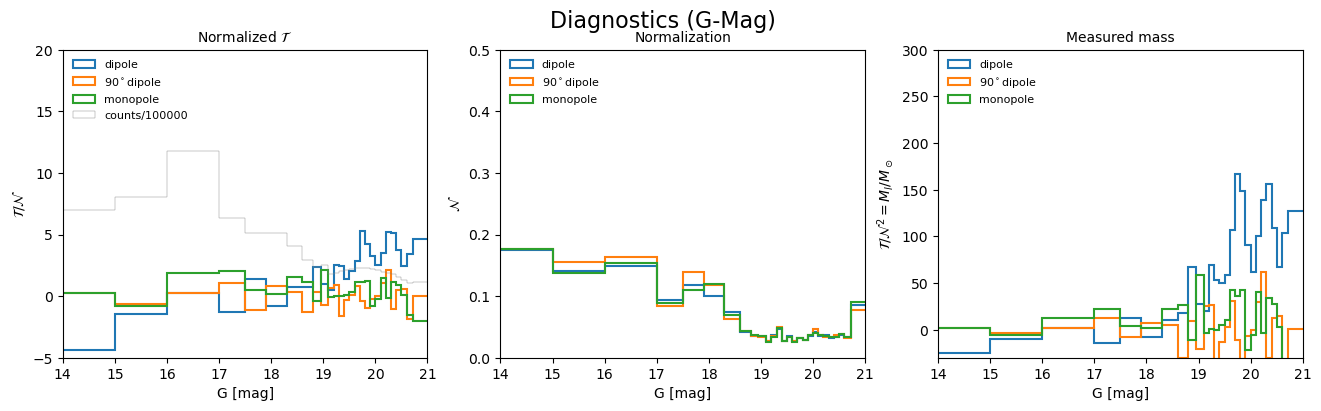

In [82]:
fig,ax = plt.subplots(1,3,figsize=(16,4))

ax[0].hist(G_bins, bins=G_bins, weights=tau_mu_list/tau_norm_list, log=False, histtype='step', linewidth=1.5);
ax[0].hist(G_bins, bins=G_bins, weights=tau_rot90_list/tau_norm_rot90_list, log=False, histtype='step', linewidth=1.5);
ax[0].hist(G_bins, bins=G_bins, weights=tau_monopole_list/tau_norm_monopole_list, log=False, histtype='step', linewidth=1.5);
ax[0].hist(G_bins, bins=G_bins, weights=G_count/100000, log=False, histtype='step', color='gray', linewidth=0.3);
ax[0].set_xlim(14,21); ax[0].set_ylim(-5,20);

ax[0].legend([r'dipole', r'$90^\circ$dipole', r'monopole', r'counts/100000'], loc='upper left', fontsize = 8, frameon=False);
ax[0].set_ylabel(r'$\mathcal{T}/\mathcal{N} $'); ax[0].set_xlabel('G [mag]');
ax[0].set_title(r'Normalized $\mathcal{T}$', fontsize = 10);

ax[1].hist(G_bins, bins=G_bins, weights=tau_norm_list, log=False, histtype='step', linewidth=1.5);
ax[1].hist(G_bins, bins=G_bins, weights=tau_norm_rot90_list, log=False, histtype='step', linewidth=1.5);
ax[1].hist(G_bins, bins=G_bins, weights=tau_norm_monopole_list, log=False, histtype='step', linewidth=1.5);
#ax[1].hist(G_bins[:-1], bins=G_bins, weights=G_count/50000, log=False, histtype='step', color='gray', linewidth=0.3);
ax[1].set_xlim(14,21); ax[1].set_ylim(0,0.5);
ax[1].legend([r'dipole', r'$90^\circ$dipole', r'monopole', r'counts/($5\times 10^4$)'], loc='upper left', fontsize = 8, frameon=False);
ax[1].set_ylabel(r'$\mathcal{N}$'); ax[1].set_xlabel('G [mag]');
ax[1].set_title(r'Normalization', fontsize = 10);

ax[2].hist(G_bins, bins=G_bins, weights=tau_mu_list/tau_norm_list**2, log=False, histtype='step', linewidth=1.5);
ax[2].hist(G_bins, bins=G_bins, weights=tau_rot90_list/tau_norm_rot90_list**2, log=False, histtype='step', linewidth=1.5);
ax[2].hist(G_bins, bins=G_bins, weights=tau_monopole_list/tau_norm_monopole_list**2, log=False, histtype='step', linewidth=1.5);
#ax[2].hist(G_bins[:-1], bins=G_bins, weights=G_count/1000, log=False, histtype='step', color='gray', linewidth=0.3);
ax[2].set_xlim(14,21); ax[2].set_ylim(-30,300);

ax[2].legend([r'dipole', r'$90^\circ$dipole', r'monopole', r'counts/200'], loc='upper left', fontsize = 8, frameon=False);
ax[2].set_ylabel(r'$\mathcal{T}/\mathcal{N}^2 = M_l/M_\odot $'); ax[2].set_xlabel('G [mag]');
ax[2].set_title(r'Measured mass', fontsize = 10);

#plt.tight_layout()
fig.suptitle(r'Diagnostics (G-Mag)', fontsize = 16)
fig.show()
#fig.savefig(FigDir+'tau_vs_gmag.pdf')

# bil diagnostics

In [113]:
fg_ra = df_foresmaller['ra'] 
fg_dec = df_foresmaller['dec']
fg_pmra= df_foresmaller['pmra'] 
fg_pmdec= df_foresmaller['pmdec']


bg_ra = df_backsmaller['ra']
bg_dec = df_backsmaller['dec'] 
bg_pmra= df_backsmaller['pmra_sub_new'] 
bg_pmdec= df_backsmaller['pmdec_sub_new'] 

#bil separation vectors
l_bilvec = fn_angular_sep(fg_ra*degree, fg_dec*degree, bg_ra*degree, bg_dec*degree)
l_bilnormsq = l_bilvec[:, 0]**2 + l_bilvec[:, 1]**2
l_sep = np.sqrt(l_bilnormsq)/arcsec
df_foresmaller['l_sep'] = l_sep
df_backsmaller['l_sep'] = l_sep

bil_bins = np.arange(0,3,0.4)#np.array([5, 15, 16, 17, 17.5, 17.9, 18.3, 18.6, 18.8, 18.95, 19.1, 19.2, 19.3, 19.4, 19.5, 19.6, 19.7, 19.8, 19.9, 20, 20.1, 20.2, 20.3, 20.4, 20.5, 20.6, 20.72, 22])
q_bil = np.digitize(l_sep, bil_bins)-1
df_foresmaller['q_bil'] = q_bil
df_backsmaller['q_bil'] = q_bil
print(bil_bins[q_bil])

/tmp/ipykernel_1834950/3201154997.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_foresmaller['l_sep'] = l_sep
/tmp/ipykernel_1834950/3201154997.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_backsmaller['l_sep'] = l_sep
/tmp/ipykernel_1834950/3201154997.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

[2.8 2.4 2.4 ... 2.8 2.4 2.8]


/tmp/ipykernel_1834950/3201154997.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_backsmaller['q_bil'] = q_bil


In [114]:
df_foreground = df_foresmaller.sort_values(by=['q_bil'], ascending=True)
df_background = df_backsmaller.sort_values(by=['q_bil'], ascending=True)
df_foreground['q_bil']

1605322    0
1476104    0
8219957    0
1455961    0
1548744    0
          ..
5014818    7
5014827    7
5014838    7
5014736    7
8763141    7
Name: q_bil, Length: 8711533, dtype: int64

In [115]:
bil_count = np.bincount(df_foresmaller['q_bil'])
print(len(bil_count), len(bil_bins), sum(bil_count)) 

8 8 8711533


In [116]:
tau_mu_list, tau_norm_list = np.zeros(len(bil_count)), np.zeros(len(bil_count))
tau_rot90_list, tau_norm_rot90_list = np.zeros(len(bil_count)), np.zeros(len(bil_count))
tau_monopole_list, tau_norm_monopole_list = np.zeros(len(bil_count)), np.zeros(len(bil_count))
tau_quad_list, tau_norm_quad_list = np.zeros(len(bil_count)), np.zeros(len(bil_count))
gmag_mean = np.zeros(len(bil_count))

last = 0
for i in tqdm(range(len(bil_count))):
    df_fore_sub = df_foreground.iloc[last:last+bil_count[i]] 
    df_back_sub = df_background.iloc[last:last+bil_count[i]]
    last += bil_count[i]
    print(len(df_fore_sub))
    
    gmag_mean[i] = np.mean(df_fore_sub['l_sep'].to_numpy())
    
    inv_cov_pm = np.linalg.inv(fn_cov_pm_eff(df_back_sub))

    tau_mu_list[i], tau_norm_list[i] = fn_tau_mu(df_fore_sub, df_back_sub, inv_cov_pm, tau_obs=tau_obs, matched_filter=fn_dipole_mf)
    tau_rot90_list[i], tau_norm_rot90_list[i] = fn_tau_mu(df_fore_sub, df_back_sub, inv_cov_pm, tau_obs=tau_obs, matched_filter=fn_dipole_mf, rot_angle=90*degree)
    tau_monopole_list[i], tau_norm_monopole_list[i] = fn_tau_mu(df_fore_sub, df_back_sub, inv_cov_pm, tau_obs=tau_obs, matched_filter=fn_monopole_mf)
    tau_quad_list[i], tau_norm_quad_list[i] = fn_tau_mu(df_fore_sub, df_back_sub, inv_cov_pm, tau_obs=tau_obs, matched_filter=fn_quadrupole_mf)
        
    del df_fore_sub
    del df_back_sub
print(last)

  0%|          | 0/8 [00:00<?, ?it/s]

11
23684
255057


 38%|███▊      | 3/8 [00:00<00:00,  8.49it/s]

889000


 50%|█████     | 4/8 [00:01<00:01,  2.19it/s]

1593162


 62%|██████▎   | 5/8 [00:04<00:03,  1.10s/it]

2077966


 75%|███████▌  | 6/8 [00:07<00:03,  1.75s/it]

2484914


 88%|████████▊ | 7/8 [00:11<00:02,  2.40s/it]

1387739


100%|██████████| 8/8 [00:13<00:00,  1.66s/it]

8711533


In [117]:
tau_mu_list/tau_norm_list

array([ 1.12617008,  5.99203203,  6.28035119,  1.48960286,  0.01065665,
       -1.70207277, -1.54234353, -0.63714261])

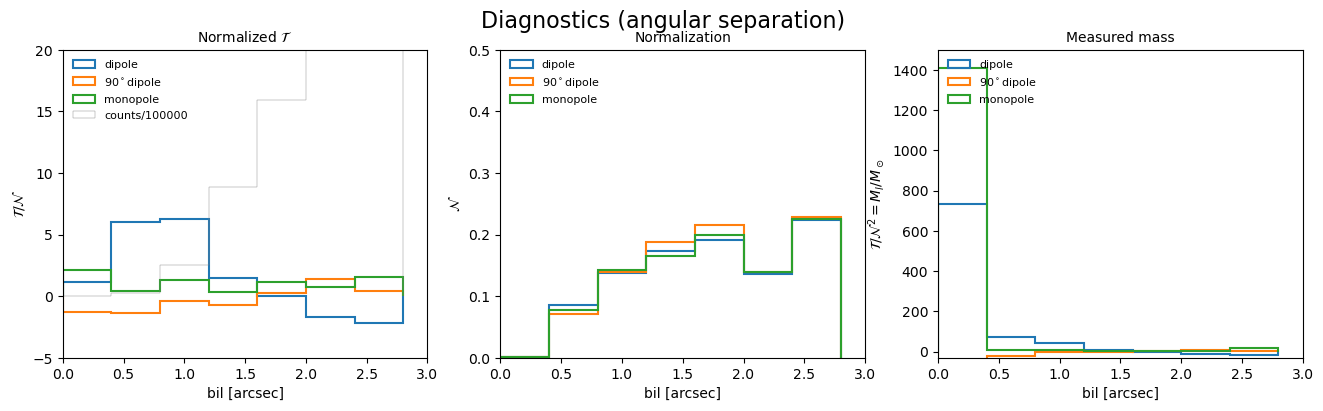

In [125]:
fig,ax = plt.subplots(1,3,figsize=(16,4))

ax[0].hist(bil_bins, bins=bil_bins, weights=tau_mu_list/tau_norm_list, log=False, histtype='step', linewidth=1.5);
ax[0].hist(bil_bins, bins=bil_bins, weights=tau_rot90_list/tau_norm_rot90_list, log=False, histtype='step', linewidth=1.5);
ax[0].hist(bil_bins, bins=bil_bins, weights=tau_monopole_list/tau_norm_monopole_list, log=False, histtype='step', linewidth=1.5);
ax[0].hist(bil_bins, bins=bil_bins, weights=bil_count/100000, log=False, histtype='step', color='gray', linewidth=0.3);
ax[0].set_xlim(0,3); ax[0].set_ylim(-5,20);

ax[0].legend([r'dipole', r'$90^\circ$dipole', r'monopole', r'counts/100000'], loc='upper left', fontsize = 8, frameon=False);
ax[0].set_ylabel(r'$\mathcal{T}/\mathcal{N} $'); ax[0].set_xlabel('bil [arcsec]');
ax[0].set_title(r'Normalized $\mathcal{T}$', fontsize = 10);

ax[1].hist(bil_bins, bins=bil_bins, weights=tau_norm_list, log=False, histtype='step', linewidth=1.5);
ax[1].hist(bil_bins, bins=bil_bins, weights=tau_norm_rot90_list, log=False, histtype='step', linewidth=1.5);
ax[1].hist(bil_bins, bins=bil_bins, weights=tau_norm_monopole_list, log=False, histtype='step', linewidth=1.5);
#ax[1].hist(G_bins[:-1], bins=G_bins, weights=G_count/50000, log=False, histtype='step', color='gray', linewidth=0.3);
ax[1].set_xlim(0,3); ax[1].set_ylim(0,0.5);
ax[1].legend([r'dipole', r'$90^\circ$dipole', r'monopole', r'counts/($5\times 10^4$)'], loc='upper left', fontsize = 8, frameon=False);
ax[1].set_ylabel(r'$\mathcal{N}$'); ax[1].set_xlabel('bil [arcsec]');
ax[1].set_title(r'Normalization', fontsize = 10);

ax[2].hist(bil_bins, bins=bil_bins, weights=tau_mu_list/tau_norm_list**2, log=False, histtype='step', linewidth=1.5);
ax[2].hist(bil_bins, bins=bil_bins, weights=tau_rot90_list/tau_norm_rot90_list**2, log=False, histtype='step', linewidth=1.5);
ax[2].hist(bil_bins, bins=bil_bins, weights=tau_monopole_list/tau_norm_monopole_list**2, log=False, histtype='step', linewidth=1.5);
#ax[2].hist(G_bins[:-1], bins=G_bins, weights=G_count/1000, log=False, histtype='step', color='gray', linewidth=0.3);
ax[2].set_xlim(0,3); ax[2].set_ylim(-30,1500);

ax[2].legend([r'dipole', r'$90^\circ$dipole', r'monopole', r'counts/200'], loc='upper left', fontsize = 8, frameon=False);
ax[2].set_ylabel(r'$\mathcal{T}/\mathcal{N}^2 = M_l/M_\odot $'); ax[2].set_xlabel('bil [arcsec]');
ax[2].set_title(r'Measured mass', fontsize = 10);

#plt.tight_layout()
fig.suptitle(r'Diagnostics (angular separation)', fontsize = 16)
fig.show()
#fig.savefig(FigDir+'tau_vs_gmag.pdf')

(array([7.000000e+00, 3.000000e+01, 1.110000e+02, 7.450000e+02,
        3.359000e+03, 1.105600e+04, 2.962500e+04, 7.072300e+04,
        1.406190e+05, 2.690780e+05, 4.740240e+05, 7.952670e+05,
        1.249415e+06, 1.804315e+06, 2.387660e+06, 3.102816e+06,
        4.416697e+06, 6.174323e+06, 5.987293e+06, 1.143088e+06]),
 array([ 7.4897914 ,  8.17949433,  8.86919726,  9.55890019, 10.24860312,
        10.93830605, 11.62800898, 12.31771191, 13.00741484, 13.69711777,
        14.3868207 , 15.07652363, 15.76622656, 16.45592949, 17.14563242,
        17.83533535, 18.52503828, 19.21474121, 19.90444414, 20.59414707,
        21.28385   ]),
 <BarContainer object of 20 artists>)

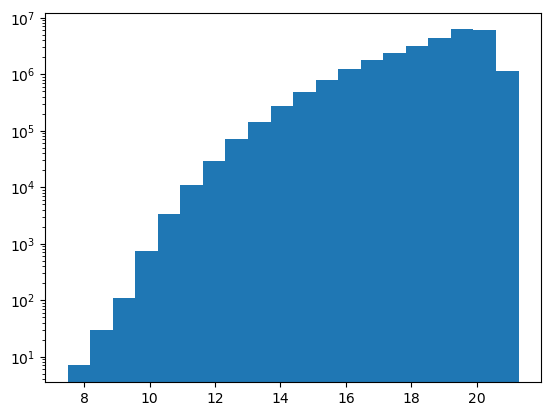

In [ ]:
plt.hist(df_fore['phot_g_mean_mag'], log = True, bins = 20)

In [ ]:
G_bins

array([ 5.  , 15.  , 16.  , 17.  , 17.5 , 17.9 , 18.3 , 18.6 , 18.8 ,
       18.95, 19.1 , 19.2 , 19.3 , 19.4 , 19.5 , 19.6 , 19.7 , 19.8 ,
       19.9 , 20.  , 20.1 , 20.2 , 20.3 , 20.4 , 20.5 , 20.6 , 20.72,
       22.  ])

# Impact param anisotropy

In [53]:
foregrounds = df_foresmaller
backgrounds = df_backsmaller

In [54]:
### Impact parameter and unit vector in the direction of the impact parameter
b_il = fn_angular_sep(foregrounds['ra'].to_numpy()*degree, foregrounds['dec'].to_numpy()*degree, 
                      backgrounds['ra'].to_numpy()*degree, backgrounds['dec'].to_numpy()*degree)
b_il_norm = np.sqrt(b_il[:, 0]**2+b_il[:, 1]**2)
b_il_hat = np.array([b_il[:, 0]/b_il_norm, b_il[:, 1]/b_il_norm]).T 

In [55]:
### Lens velocity unit vector
#vl_vec = np.array([foregrounds['pmra'].to_numpy() - backgrounds['pmra'].to_numpy() , foregrounds['pmdec'].to_numpy() - backgrounds['pmdec'].to_numpy()]).T

#vl_vec = np.array([foregrounds['pmra'].to_numpy() - backgrounds['pmra_sub'].to_numpy() , foregrounds['pmdec'].to_numpy() - backgrounds['pmdec_sub'].to_numpy()]).T
#vl_vec = np.array([fg_pmra - bg_pmra, fg_pmdec - bg_pmdec]).T*mas/Year
vl_vec = np.array([foregrounds['pmra'].to_numpy() , foregrounds['pmdec'].to_numpy()]).T

vl_norm = np.sqrt(vl_vec[:, 0]**2 + vl_vec[:, 1]**2)
vl_hat = np.array([vl_vec[:, 0]/vl_norm, vl_vec[:, 1]/vl_norm]).T 

In [56]:
### Angle between the impact parameter and the velocity unit vector
cos_theta = b_il_hat[:,0]*vl_hat[:,0] + b_il_hat[:,1]*vl_hat[:,1]
theta = np.arccos(cos_theta)

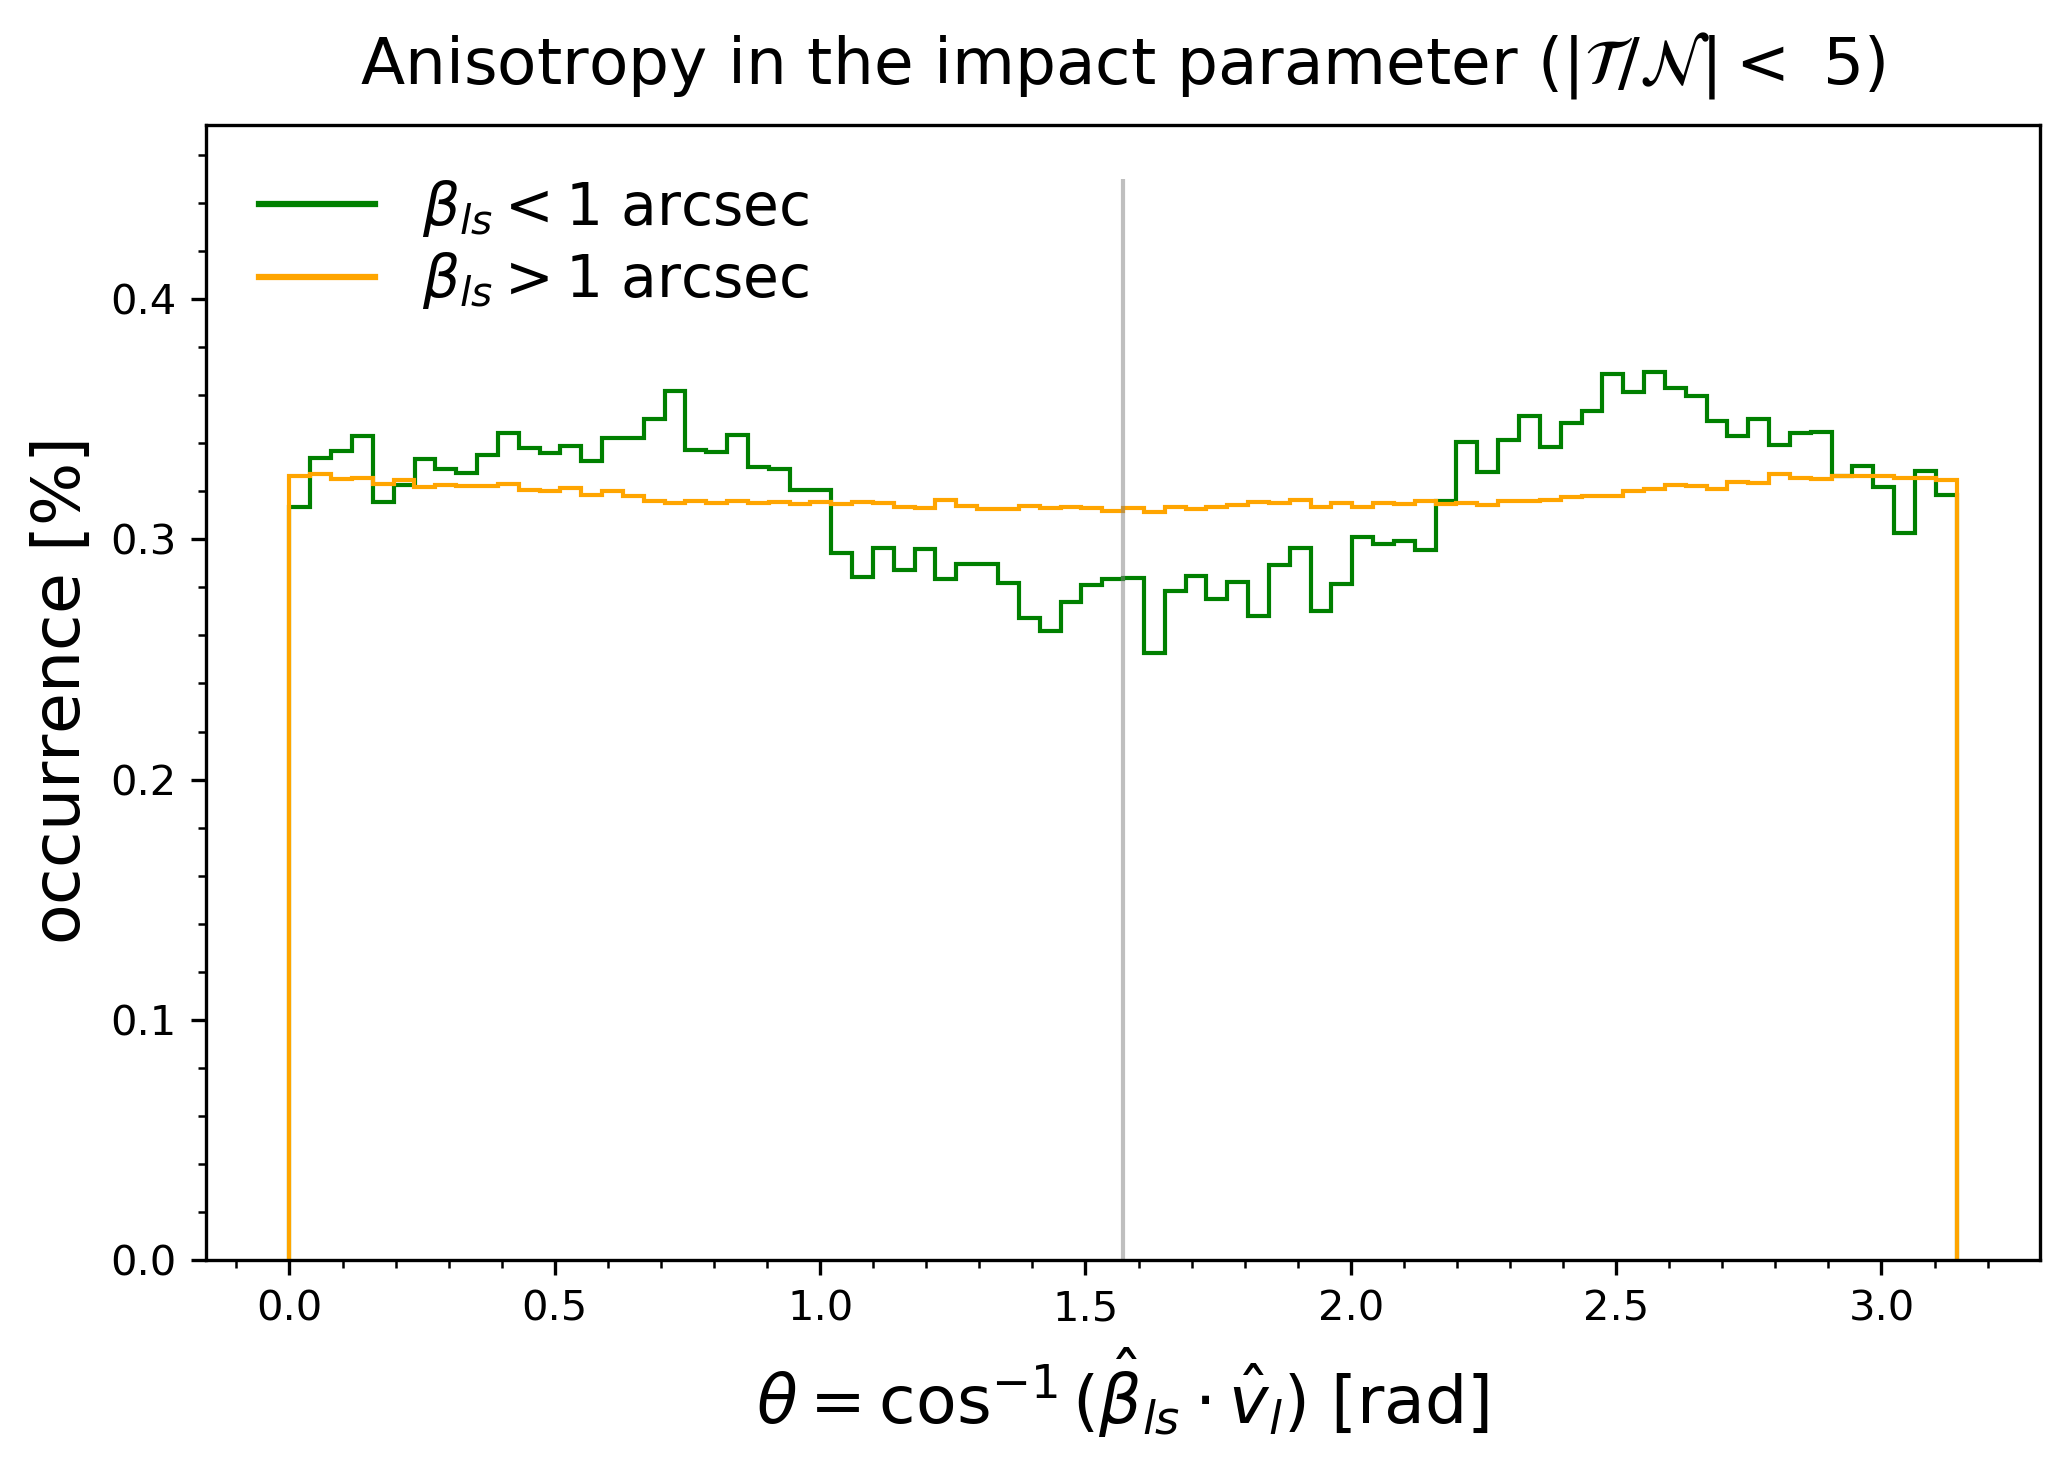

In [57]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5), dpi=300)
colorlist = ['green', 'orange']
beta_th = 1

ax.minorticks_on()

ax.hist(theta[b_il_norm/arcsec < beta_th], bins=80, log=False, density=True, histtype='step', color=colorlist[0]);
ax.hist(theta[b_il_norm/arcsec >= beta_th], bins=80, log=False, density=True, histtype='step', color=colorlist[1]);
#ax.hist(theta[b_il_norm/arcsec >= beta_th], bins=80, log=False, density=True, histtype='step', color=colorlist[2]);
ax.set_title(r'Anisotropy in the impact parameter ($|\mathcal{T}/\mathcal{N}| <$ ' + str(cutoff_tau) + ')', pad=10, fontsize=15.5)
ax.set_xlabel(r'$\theta = \cos^{-1} (\hat{\beta}_{ls} \cdot \hat{v}_{l})$ [rad]', fontsize=16); ax.set_ylabel(r'occurrence [$\%$]', fontsize=16);

p = [plt.plot([0, 3], [0, 0], color=colorlist[i])[0] for i in range(2)] 
ax.legend(p, [r'$\beta_{ls} < '+str(beta_th)+' $ arcsec', r'$\beta_{ls} > '+str(beta_th)+' $ arcsec'], loc='upper left', frameon=False, labelspacing=0.2, fontsize=14);
[p[i].set_visible(False) for i in range(len(p))]

ax.vlines(math.pi/2, 0, 0.45, color='grey', linewidth = 1, alpha=0.5)

fig.tight_layout()
#fig.savefig(FigDir+'Impact_param_anisotropy.pdf')

In [58]:
print(len(theta[b_il_norm/arcsec < beta_th]), len(theta[b_il_norm/arcsec >= beta_th])); sys.stdout.flush()

840966 38282820
